In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import sys, os, glob, fnmatch
from scipy import optimize
from astropy.io import fits
import pandas as pd

from numpy.polynomial.legendre import legval
from lmfit import models, Parameters, Parameter, Model
from lmfit.models import LinearModel, ConstantModel
from scipy.interpolate import interp1d
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from scipy.special import eval_legendre

from matplotlib.font_manager import FontProperties
import matplotlib.ticker as ticker
from matplotlib.ticker import FuncFormatter
font = FontProperties()
font.set_family('serif')
font.set_size('small')

In [2]:
plt.rc('font', size=14, family='serif')

# BOSS ArcLines

We can grab the arclines from the BOSS observations to get a good measurements of the line spreading from the BOSS spectrographs. When we can constrain the shape of the arcline, we can apply this to the sky lines and remove them from the continuum.

In [3]:
#Get Arc files
ARC_DIR = '/Users/parkerf/Desktop/test_data/arcs/'
all_arc_files = glob.glob(ARC_DIR+"/**/*.fits.gz",recursive=True)

In [4]:
blue_arc_files = fnmatch.filter(all_arc_files,"*-b*-*")
red_arc_files = fnmatch.filter(all_arc_files,"*-r*-*")

In [5]:
def eval_tset(fiber_num, tset):
    #Calculates the wavelength solution in the arc files
    nx = tset.XMAX - tset.XMIN + 1
    xmid = .5*(tset.XMIN+tset.XMAX)
    x_range = tset.XMAX - tset.XMIN
    xloc = np.linspace(tset.XMIN, tset.XMAX, nx)

    dims = tset.COEFF[0].shape
    xpos = np.tile(xloc,(dims[0],1))
    xpos = xpos % nx

    ypos = np.zeros(xpos.shape)

    xinput = xpos[fiber_num]
    xvec  = 2.0*(xinput-xmid)/x_range

    spectrum = legval(xvec, tset.COEFF[0][fiber_num])
    return spectrum

In [6]:
def extract_data(file, num):
    hdu = fits.open(file)
    flux = hdu[0].data[num]
    sigmas = eval_tset(num, hdu[4].data)
    log_wave = eval_tset(num, hdu[2].data)
    wave = 10**(log_wave)
    arc_lines = hdu[1].data[:,0]
    
    return flux, sigmas, wave, arc_lines

In [31]:
bflux, bsigma, bwave, barc_lines1 = extract_data(blue_arc_files[0],10)
bflux, bsigma, bwave, barc_lines2 = extract_data(blue_arc_files[10],105)

/Users/parkerf/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:6: DeprecationWarning: object of type <class 'numpy.ndarray'> cannot be safely interpreted as an integer.


#### The Arcline identified in each SpArc are the same

In [505]:
print(barc_lines1)
print(barc_lines2)

[ 3610.508   3650.157   3654.839   3983.839   4046.572   4077.838   4306.672
  4339.22    4347.506   4358.337   4412.989   4662.352   4678.149   4799.912
  4916.07    5085.822   5330.7775  5341.0938  5400.5616  5460.753
  5656.6588  5675.86    5689.8163  5719.53    5769.598   5790.663
  5820.1558  5852.488   5881.895   5944.834   5965.471   6029.997   6074.338
  6096.163   6143.063   6163.594   6217.281   6266.495   6304.789   6334.428
  6382.992   6402.246   6438.47    6506.528   6532.882 ]
[ 3610.508   3650.157   3654.839   3983.839   4046.572   4077.838   4306.672
  4339.22    4347.506   4358.337   4412.989   4662.352   4678.149   4799.912
  4916.07    5085.822   5330.7775  5341.0938  5400.5616  5460.753
  5656.6588  5675.86    5689.8163  5719.53    5769.598   5790.663
  5820.1558  5852.488   5881.895   5944.834   5965.471   6029.997   6074.338
  6096.163   6143.063   6163.594   6217.281   6266.495   6304.789   6334.428
  6382.992   6402.246   6438.47    6506.528   6532.882 ]


In [36]:
len(barc_lines2)

45

In [33]:
bflux, bsigma, bwave, rarc_lines1 = extract_data(red_arc_files[0],10)
bflux, bsigma, bwave, rarc_lines2 = extract_data(red_arc_files[10],105)

/Users/parkerf/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:6: DeprecationWarning: object of type <class 'numpy.ndarray'> cannot be safely interpreted as an integer.


In [507]:
print(rarc_lines1)
print(rarc_lines2)

[  5400.5616   5460.753    5656.6588   5675.86     5689.8163   5719.53
   5769.598    5790.663    5820.1558   5852.488    5881.895    5944.834
   5965.471    6029.997    6074.338    6096.163    6143.063    6163.594
   6217.281    6266.495    6304.789    6334.428    6382.992    6402.246
   6438.47     6506.528    6532.882    6598.953    6717.043    6929.467
   7032.4128   7173.938    7245.167    7438.9      7488.871    7503.8691
   7514.6518   7535.774    7635.106    8014.786    8103.693    8300.326
   8377.6065   8408.2096   8495.3598   8521.4422   8591.2583   8634.647
   8654.3831   8853.867    8919.5007   9122.9674   9201.759    9300.853
   9313.1386   9326.507    9425.379    9459.21     9486.68     9534.163
   9547.4      9657.786    9665.424    9784.503   10139.75  ]
[  5400.5616   5460.753    5656.6588   5675.86     5689.8163   5719.53
   5769.598    5790.663    5820.1558   5852.488    5881.895    5944.834
   5965.471    6029.997    6074.338    6096.163    6143.063    6163.594
   

In [509]:
len(rarc_lines1)

65

### Make Mean Arcline Spectrum

Lines differ a bit over a plate due to small changes in the throughput, etc. We don't care too much about that as we won't be creating a model per wavelength since the spFrame files are already calibrated. Instead we will just take the mean of a plate

/Users/parkerf/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:5: DeprecationWarning: object of type <class 'numpy.ndarray'> cannot be safely interpreted as an integer.


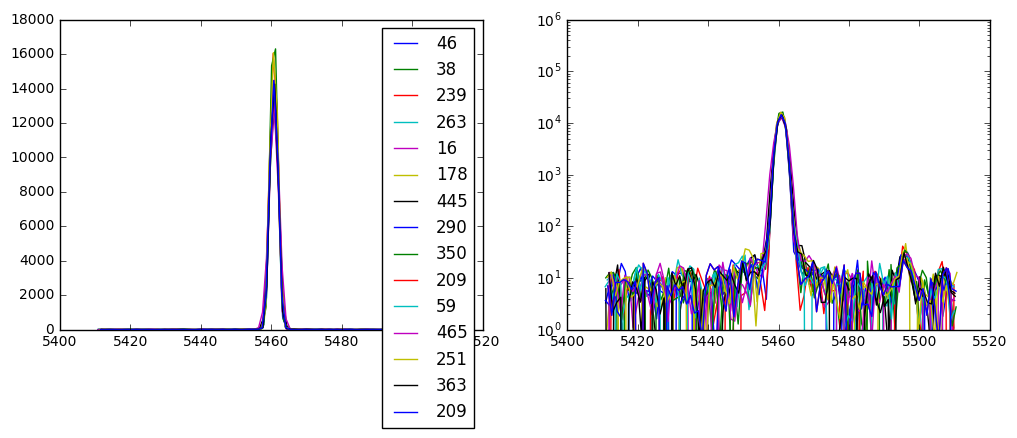

In [14]:
arc_line = my_blue_lines[7]
bfile = np.random.choice(blue_arc_files,1)[0]
fig, (ax1, ax2) = plt.subplots(1,2,figsize = (12,4))
for fiber in np.random.randint(0,high = 500, size = 15):
    flux, wave, weights = window_arclines(bfile, fiber, arc_line, window_size = 50)
    ax1.plot(wave, flux, label = fiber)
    #ax1.set_ylim(150000, 250000)
    #ax1.set_xlim([5440,5480])
    ax2.semilogy(wave, flux, label = fiber)
    ax2.set_ylim(pow(10,0), pow(10,6))
ax1.legend()

In [302]:
def make_blue_mean_arcline(blue_arc_file):
    bxx = np.linspace(3600,6500,(6500-3600)*10)
    blue_mean_arcline = []
    blue_mean_sigma = []
    for i in range(500):
        bflux, bsigma, bwave, barc_lines = extract_data(blue_arc_file,i)
        f = interp1d(bwave, bflux, bounds_error = False, fill_value = 0)
        g = interp1d(bwave, bsigma, bounds_error = False, fill_value = 0)
        blue_mean_arcline.append(f(bxx))
        blue_mean_sigma.append(g(bxx))
    blue_mean_arcline = np.mean(blue_mean_arcline, axis = 0)   
    blue_mean_sigma = np.mean(blue_mean_sigma, axis = 0)  
    return blue_mean_arcline, blue_mean_sigma

In [306]:
def make_red_mean_arcline(red_arc_file):
    rxx = np.linspace(5700,10400,(10400-5700)*10)
    red_mean_arcline = []
    red_mean_sigma = []
    for i in range(500):
        rflux, rsigma, rwave, rarc_lines = extract_data(red_arc_file,i)
        f = interp1d(rwave, rflux, bounds_error = False, fill_value = 0)
        g = interp1d(rwave, rsigma, bounds_error = False, fill_value = 0)
        red_mean_arcline.append(f(rxx))
        red_mean_sigma.append(g(rxx))
    red_mean_arcline = np.mean(red_mean_arcline, axis = 0)   
    red_mean_sigma = np.mean(red_mean_sigma, axis = 0)  
    return red_mean_arcline, red_mean_sigma

In [7]:
#I ran these functions on all files and saved them here: 
blue_mean_arcfiles = glob.glob('/Users/parkerf/Research/SkyModel/BOSS_Sky/ContFitting/FitTest/mean_arc_files/*-b*-*_mean.npy')
red_mean_arcfiles = glob.glob('/Users/parkerf/Research/SkyModel/BOSS_Sky/ContFitting/FitTest/mean_arc_files/*-r*-*_mean.npy')

In [8]:
blue_mean_arcline = np.load(blue_mean_arcfiles[0])
red_mean_arcline = np.load(red_mean_arcfiles[0])

## Pick out Arc Lines to look at that are sufficiently spread out

In [9]:
my_blue_lines_more = np.load('/Users/parkerf/Research/SkyModel/BOSS_Sky/ContFitting/FitTest/files/blue_arc_lines.npy')
my_blue_lines = [ 4799.912 ,  4916.07  , 5460.753 ,  6029.997 , ]

In [10]:
my_red_lines_more = np.load('/Users/parkerf/Research/SkyModel/BOSS_Sky/ContFitting/FitTest/files/red_arc_lines.npy')
my_red_lines = [ 6598.953 ,   7173.938 ,   8300.326 ,   10139.75  ]

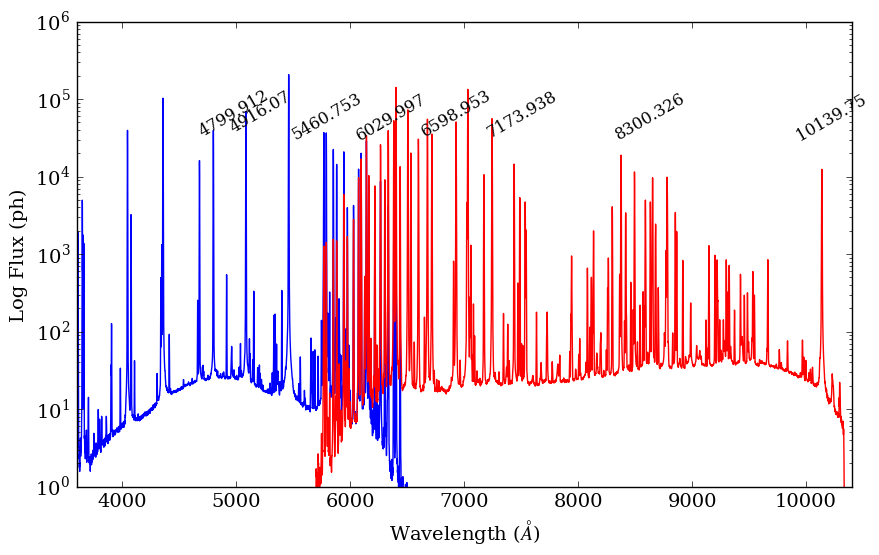

In [11]:
plt.figure(figsize=(10,6))
xxb = np.linspace(3600,6500,(6500-3600)*10)
xxr = np.linspace(5700,10400,(10400-5700)*10)
plt.semilogy(xxb, blue_mean_arcline,'b-')
plt.semilogy(xxr, red_mean_arcline,'r-')
for i, line in enumerate(my_blue_lines):
    if i == 0:
        plt.text(line-150, 100000-i*4000, line, rotation=30, fontproperties=font)
    else:
        plt.text(line, 100000-i*4000, line, rotation=30, fontproperties=font)
for i, line in enumerate(my_red_lines):
    if i == 3:
        plt.text(line-250, 100000-i*3500, line, rotation= 30,fontproperties=font)
    else:
        plt.text(line, 100000-i*3500, line, rotation= 30,fontproperties=font)
plt.xlim(3600,10400)
plt.ylim(pow(10,0),pow(10,6))
plt.xlabel("Wavelength ($\AA$)")
plt.ylabel("Log Flux (ph)")
plt.savefig("/Users/parkerf/Research/Thesis/thesis_doc/images/arcline_spectrum.png")

# Model Arc Lines

The arcline shape is impacted by the spot size on the detector. We expect it to have the following characteristics:
* Slightly change as function of wavelength and location on detector (fiber number) 
* Since spot size is shape of fiber (top hat) convolved wiht gaussian, this should look like two gaussians.
* Expect scatter from grating to correspond to a lorentzian shape and not change from line to line. Therefore we should be able to fix the lorentzian wings for all arclines
* Should have no background. (Note: seem to have some level of background, ~ 18 electrons)

In [12]:
def window_arclines(color, line, window_size, mean_flux):
    
    if color == 'blue':
        wave = np.linspace(3600,6500,(6500-3600)*10)
    elif color == 'red':
        wave = np.linspace(5700,10400,(10400-5700)*10)
    flux = mean_flux
    start, stop = [line-window_size, line+window_size]
    section = np.where((wave>start)&(wave<stop))
    window_flux= flux[section]
    window_flux[window_flux<0] = 1e-18
    window_wave = wave[section]
    
    window_weights = error_model(window_flux)
    
    return window_flux, window_wave, window_weights

In [13]:
def error_model(flux):
    sig_sq = flux #+ (0.01*flux)**2.
    ww = 1/np.sqrt(sig_sq)
    ww[ww>1e5] = 1/9
    
    return ww

In [14]:
def plot_windowed_lines(color, logplot = True):
    if color == 'blue':
        my_lines = my_blue_lines
        mean_flux = blue_mean_arcline
    elif color == 'red':
        my_lines = my_red_lines
        mean_flux = red_mean_arcline
        
    fig, ax = plt.subplots(int(np.ceil(len(my_lines)/2)),2, figsize=(15,8))
    ax = ax.flatten()
    for i, line in enumerate(my_lines):
        flux, wave, weights = window_arclines(color, line, 30, mean_flux)
        if logplot:
            ax[i].semilogy(wave, flux, label = "%d:%.2f"%(i,line))
            ax[i].set_ylim((pow(10,0),pow(10,6)))   
            ax[i].set_xlim(wave[0], wave[-1])
        else:
            ax[i].plot(wave, flux, label = line)
            ax[i].set_ylim((pow(10,0),pow(10,6)))
            ax[i].set_xlim(wave[0], wave[-1])
        ax[i].legend(prop=font)

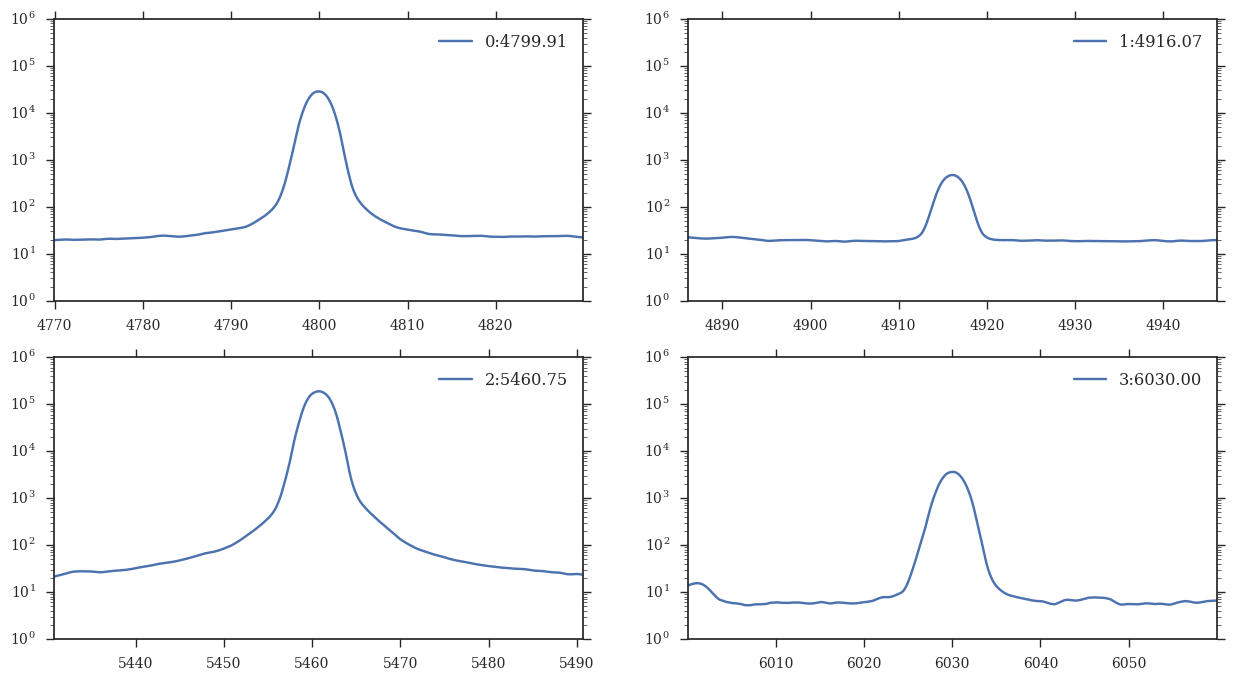

In [515]:
plot_windowed_lines('blue')

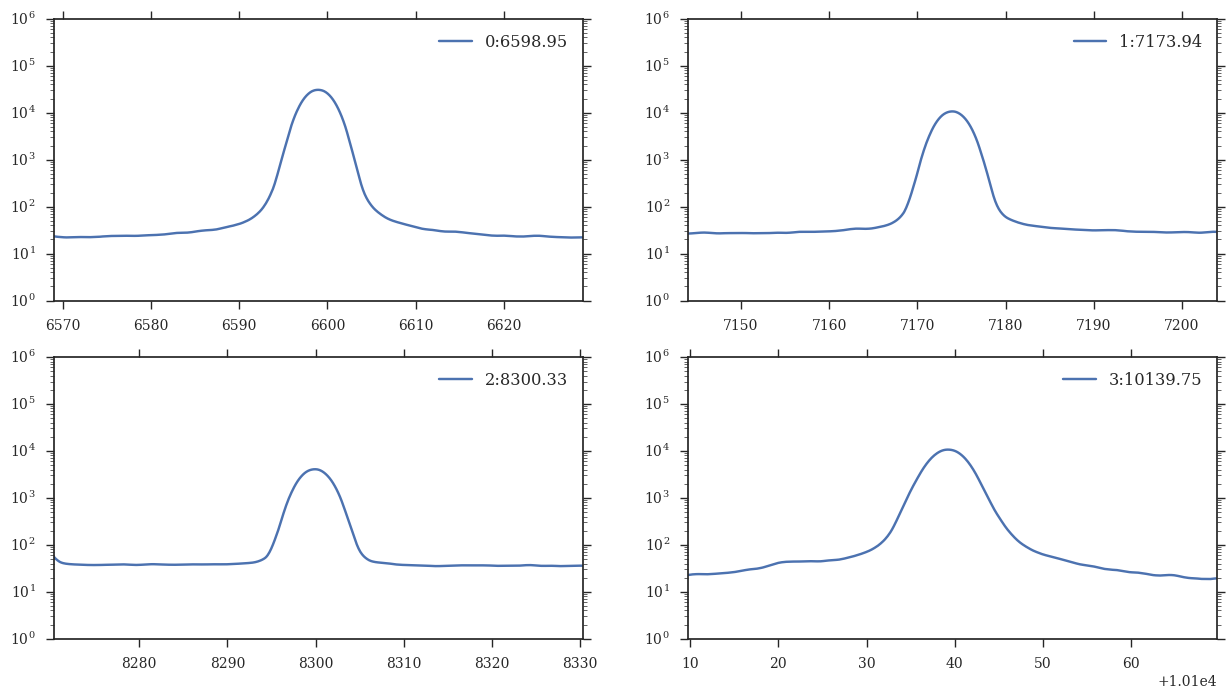

In [516]:
plot_windowed_lines('red')

### Is a Gaussian good enough?

In [71]:
def only_gaussian(line, flux, wave, weights, use_c = True):
    model_name = 'gauss'

    g = models.GaussianModel()
    params = g.guess(flux, x = wave)
    
    if use_c:
        c = models.ConstantModel()
        mod = g + c
        params.add('c', value= 18, min = 0)
    else: 
        mod = g

    model = mod.fit(flux, params, x=wave, weights=weights)
    return model

In [76]:
plt.rc('font', size=12, family='serif')

5462.229752095616
21


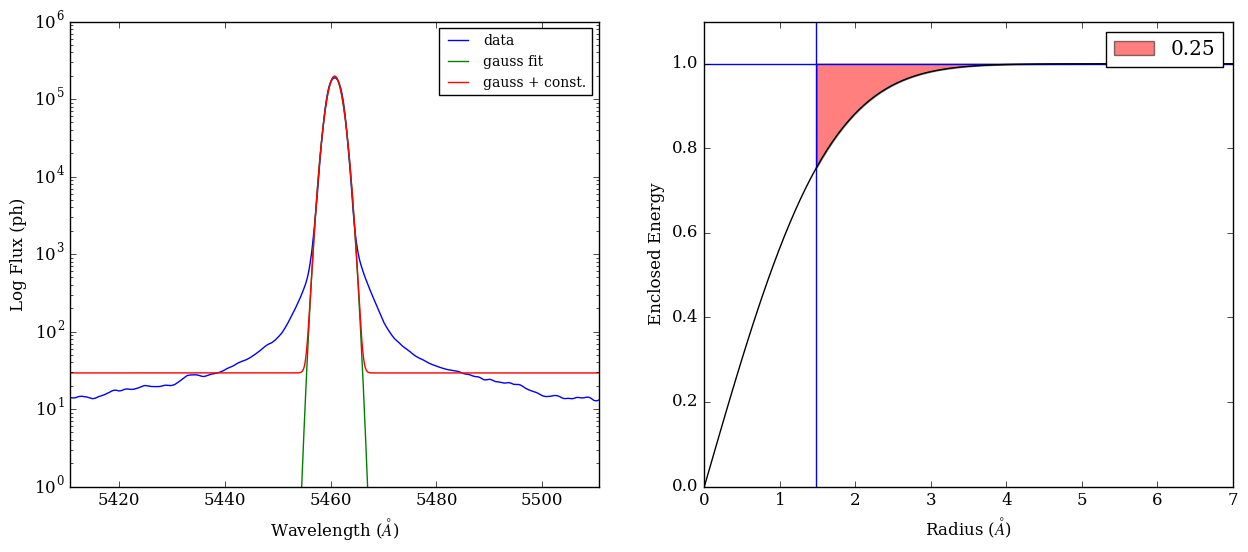

In [106]:
arc_line = my_blue_lines[2]
flux, wave, weights = window_arclines('blue', arc_line, 50)
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,6))
g_model = only_gaussian(arc_line, flux, wave, weights, use_c = False)

ax1.semilogy(wave, flux, label = 'data')
ax1.semilogy(wave, only_gaussian(arc_line, flux, wave, weights, use_c = False).best_fit, label = 'gauss fit')
ax1.semilogy(wave, only_gaussian(arc_line, flux, wave, weights, use_c = True).best_fit, label = 'gauss + const.')
ax1.set_ylim(pow(10,0),pow(10,6))
ax1.legend(prop={'size': 10})
ax1.set_xlabel("Wavelength ($\AA$)")
ax1.set_ylabel("Log Flux (ph)")
ax1.set_xlim(wave[0],wave[-1])

xx = np.linspace(g_model.params['center'],g_model.params['center']+7,100)
f = interp1d(wave, g_model.best_fit, bounds_error=False, fill_value=0)
new_flux = f(xx)

r = np.abs(g_model.params['center'].value - wave)
core_idx = np.where(xx>g_model.params['center'].value)
wing_idx = np.where(xx>start)

#calculate r
r = np.abs(g_model.params['center'] - xx)
print(g_model.params['center'].value + (g_model.params['fwhm'].value/2.))

# Calculate amount of flux outside of FWHM
total_flux = np.sum(new_flux)
e_e = []
for i, x in enumerate(xx):
    e_e.append(np.sum(new_flux[0:i])/total_flux)
m = np.argmin(np.abs(xx - (g_model.params['center'].value + (g_model.params['fwhm'].value/2.))))
wings = 1 - np.sum(new_flux[0:m])/total_flux

ax2.axvline(r[m])
ax2.axhline(1)
ax2.plot(r, e_e,'k-')
ax2.fill_between(r, e_e, 1, where=r>=r[m], alpha=0.5, facecolor = 'red',label = "%.2f" % wings)
ax2.set_ylim(0,1.1)
ax2.set_xlabel('Radius ($\AA$)')
ax2.set_ylabel('Enclosed Energy')
ax2.legend()
plt.savefig("/Users/parkerf/Research/Thesis/thesis_doc/images/gauss_fit.png")

Gaussian isn't good enough - it doesn't account for the wings and doesn't fit at the peak either. 

## Scattered Light from VPH gratings

In Woords et al, use a Lorentzian to model the scattered light. I this case we convolve it with the gaussian core shape

$Y_{fit} = sinc(b) * \frac{0.5}{N^{2}sin^{2}(a)} + A_{b}$

$b = \pi \frac{\lambda - \lambda_{blaze}}{\lambda_{0}}*f$

$a = \pi \frac{\lambda}{\lambda_{0}}$

In [15]:
def my_profile(x, amp1,amp2,center,wave1, wave2,N,a, sig1, sig2,c):

    gauss1 = amp1*np.exp(-(x-wave1)**2/(2*sig1**2.)) 
    gauss2 = amp2*np.exp(-(x-wave2)**2/(2*sig2**2.)) 
    core = gauss1 + gauss2 
    
    w = center/N * (1/(np.sqrt(2)*np.pi))
    top = w**2.
    bot = ((x-center)**2+w**2)
    scatt = a*top/bot 
    return np.convolve(core, scatt, 'same') + c

[[Model]]
    Model(my_profile)
[[Fit Statistics]]
    # function evals   = 973
    # data points      = 1000
    # variables        = 10
    chi-square         = 3202.377
    reduced chi-square = 3.235
    Akaike info crit   = 1183.893
    Bayesian info crit = 1232.971
[[Variables]]
    amp1:     474.381000 +/- 1.47e+07 (3098937.56%) (init= 100)
    amp2:     551.659639 +/- 1.71e+07 (3098956.31%) (init= 100)
    center:   5460.59458 +/- 1.099000 (0.02%) (init= 5460.753)
    wave1:    5459.93363 +/- 1.078932 (0.02%) (init= 5459.853)
    wave2:    5461.61117 +/- 1.079636 (0.02%) (init= 5461.353)
    N:        38074.2331 +/- 8.14e+05 (2137.58%) (init= 30000)
    a:        315.270440 +/- 9.78e+06 (3102218.09%) (init= 100)
    sig1:     1.01872492 +/- 0.020676 (2.03%) (init= 1)
    sig2:     1.07295891 +/- 0.024921 (2.32%) (init= 1)
    c:        15.9455316 +/- 0.379382 (2.38%) (init= 1)
[[Correlations]] (unreported correlations are <  0.100)
    C(amp1, amp2)                =  1.000 
    

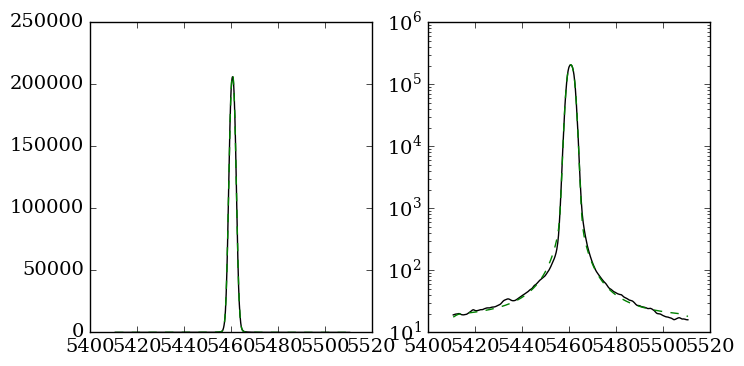

In [16]:
# We will use our brightest arcline to develop this model
arcline = my_blue_lines[2]
flux, wave, weights = window_arclines('blue', arcline, 50,blue_mean_arcline)
mod = Model(my_profile)
params = mod.make_params()
params.add('amp1', value = 100, min = 0)
params.add('amp2', value = 100, min = 0)
params.add('center', value = arcline, vary = True)
params.add('wave2', value = arcline+0.6, min = arcline, max = arcline+3)
params.add('wave1', value = arcline-0.9, min = arcline-3, max = arcline)
params.add('a', value = 100, min = 0)
params.add('N', value = 30000, vary = True)
params.add('sig1', value = 1, min = 0)
params.add('sig2', value = 1, min = 0)
params.add('c', value = 1, min = 0)

model = mod.fit(flux, params, x = wave, weights = weights)
init = mod.eval(params, x=wave)

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(8,4))
ax1.plot(wave, flux,'k-')
ax1.plot(wave,model.best_fit,'g--')
ax2.semilogy(wave, flux,'k-')
ax2.semilogy(wave,model.best_fit,'g--')
print(model.fit_report())

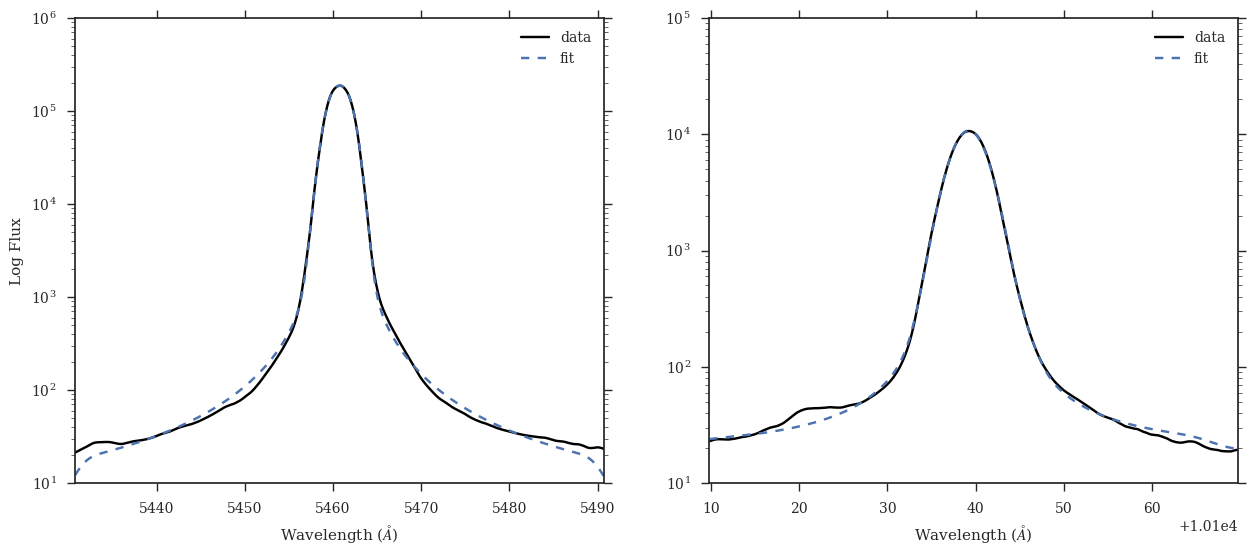

In [525]:
fig, axarr = plt.subplots(1,2, figsize = (15,6))
ax = axarr.ravel()
for i, arcline in enumerate([5460.753, 10139.75]):
    if i == 0:
        flux, wave, weights = window_arclines('blue', arcline, 30,blue_mean_arcline)
    elif i == 1:
        flux, wave, weights = window_arclines('red', arcline, 30,red_mean_arcline)
        
    mod = Model(my_profile)
    params = mod.make_params()
    params.add('amp1', value = 100, min = 0)
    params.add('amp2', value = 100, min = 0)
    params.add('center', value = arcline, vary = True)
    params.add('wave2', value = arcline+0.6, min = arcline, max = arcline+3)
    params.add('wave1', value = arcline-0.9, min = arcline-3, max = arcline)
    params.add('a', value = 100, min = 0)
    params.add('N', value = 50000, min = 0, max = 83200)
    params.add('sig1', value = 1, min = 0)
    params.add('sig2', value = 1, min = 0)
    params.add('c', value = 1, min = 0)
    model = mod.fit(flux, params, x = wave, weights = weights)
    
    ax[i].semilogy(wave, flux,'k-',label = 'data')
    ax[i].semilogy(wave,model.best_fit, '--', label = 'fit')
    ax[i].set_xlabel("Wavelength ($\AA$)")
    ax[i].set_xlim(wave[0], wave[-1])
    ax[i].legend()
ax[0].set_ylabel("Log Flux")
ax[0].set_ylim(pow(10,1),pow(10,6))
ax[1].set_ylim(pow(10,1),pow(10,5))
plt.savefig("/Users/parkerf/Research/Thesis/thesis_doc/images/init_fit.png")

#### How does it work for other lines? Looks pretty good except when there are several other lines

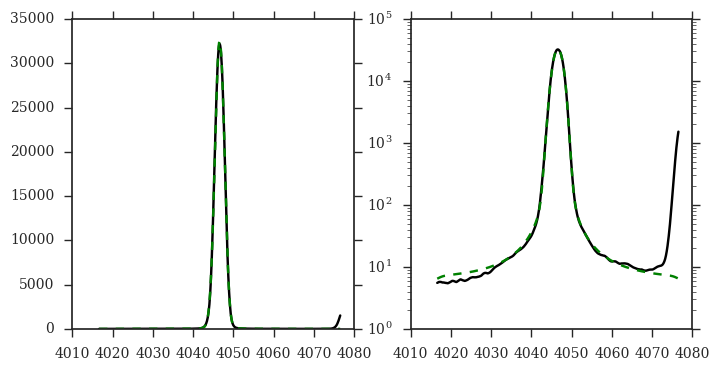

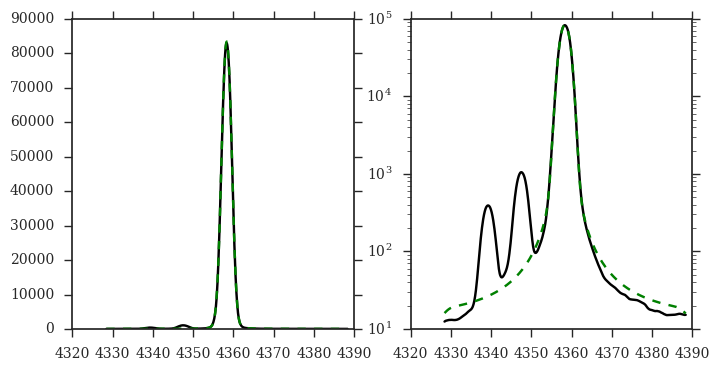

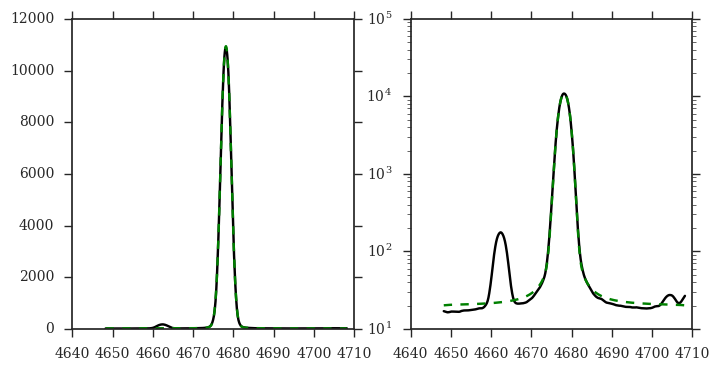

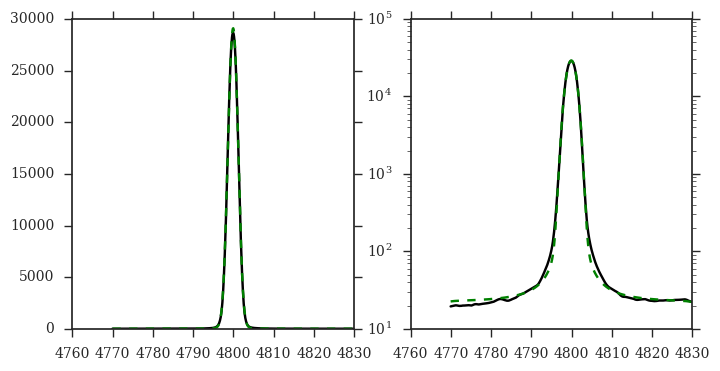

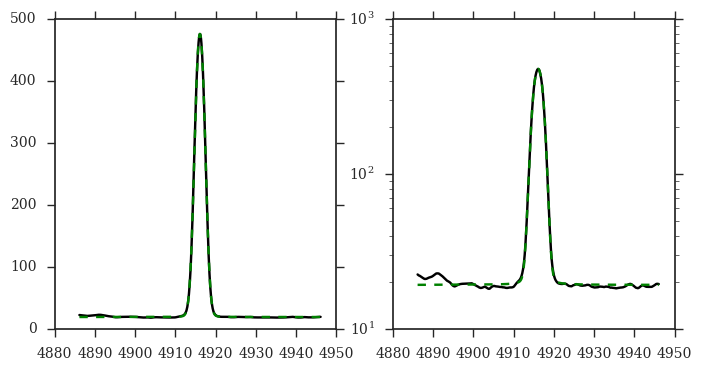

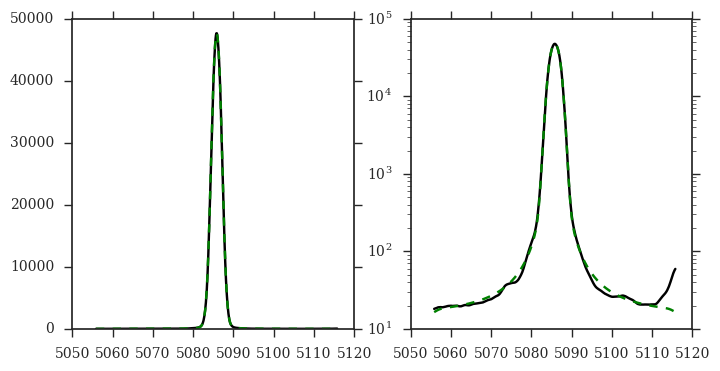

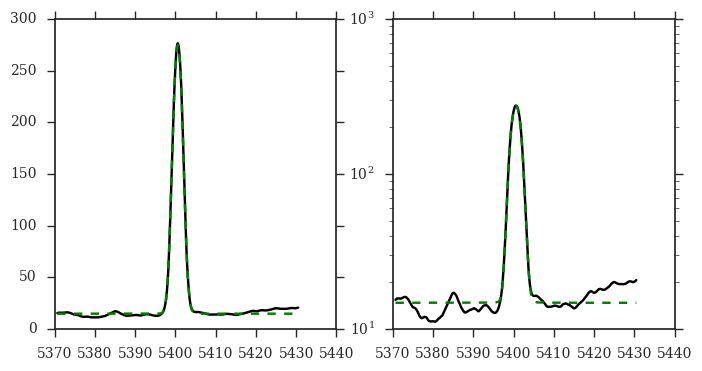

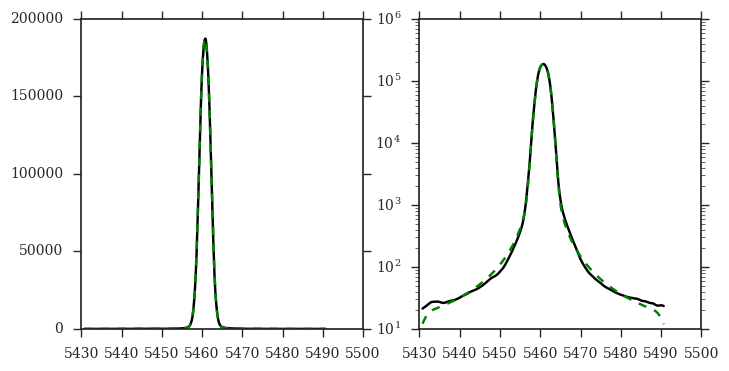

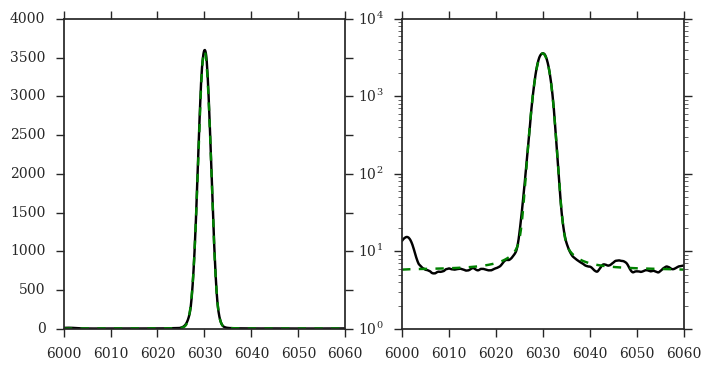

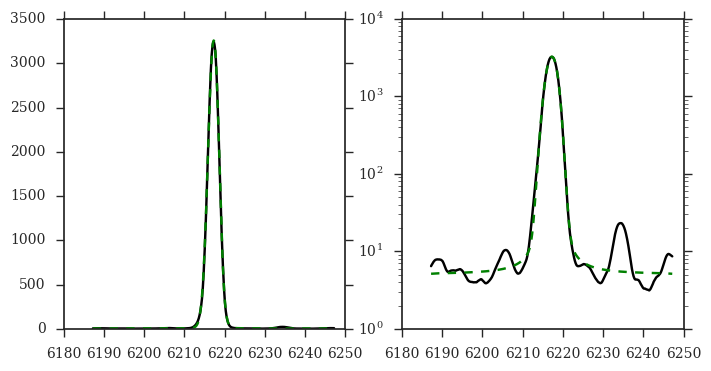

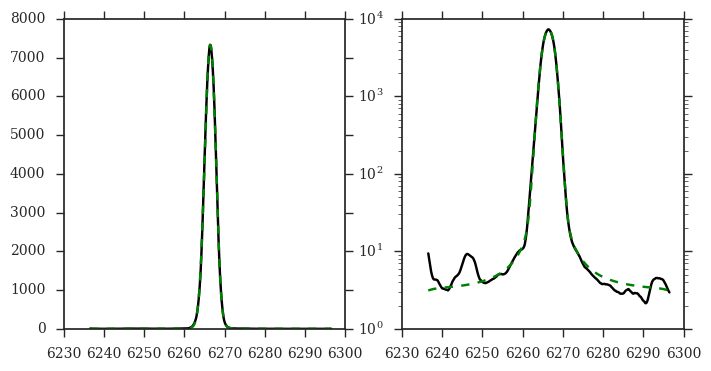

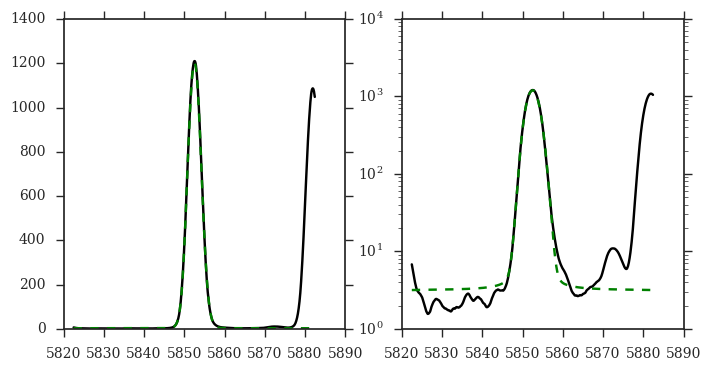

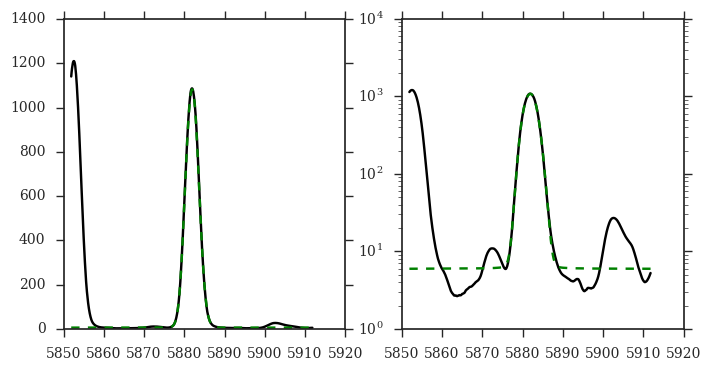

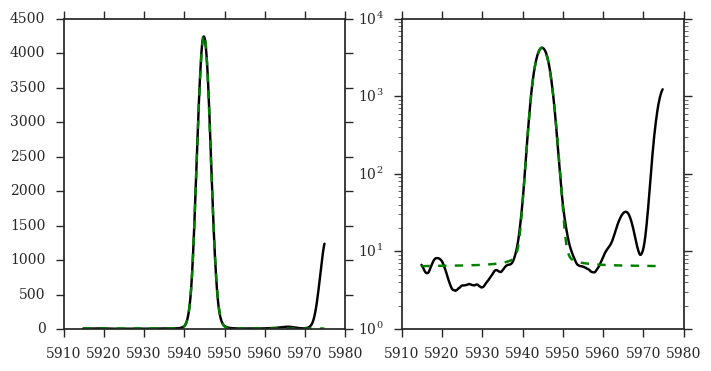

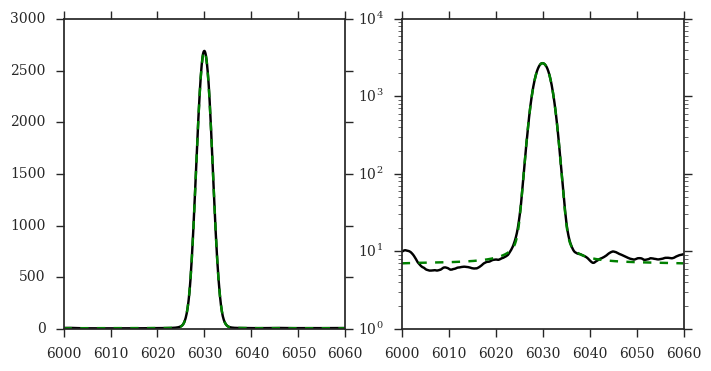

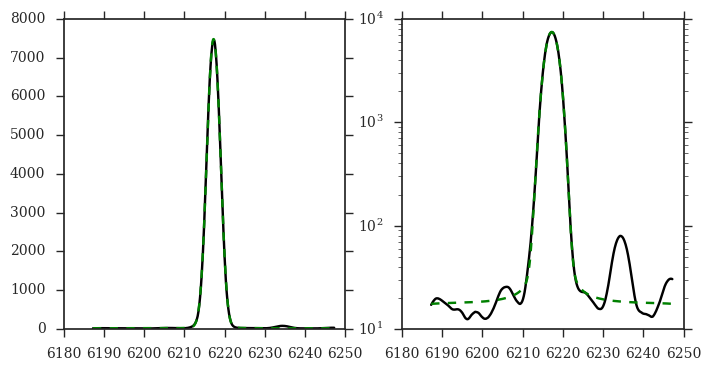

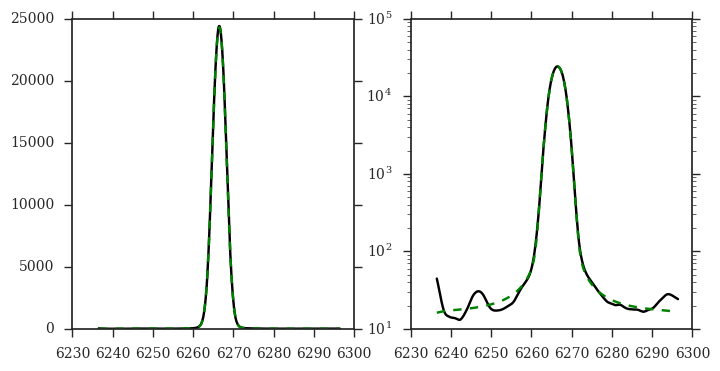

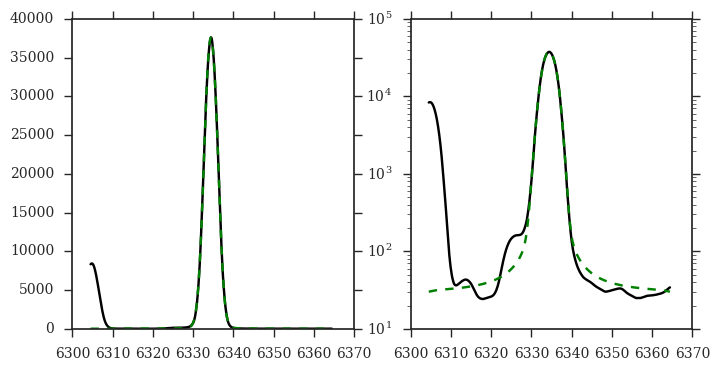

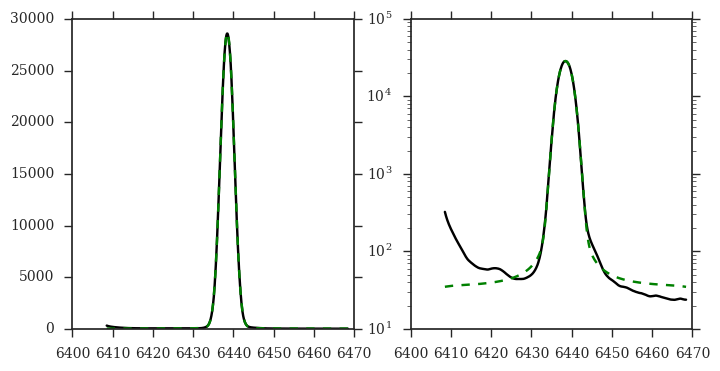

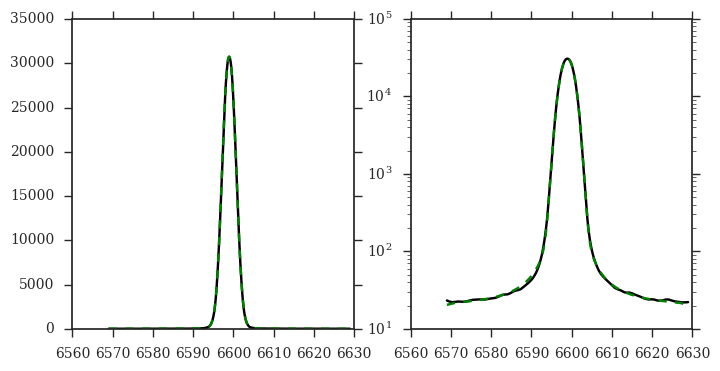

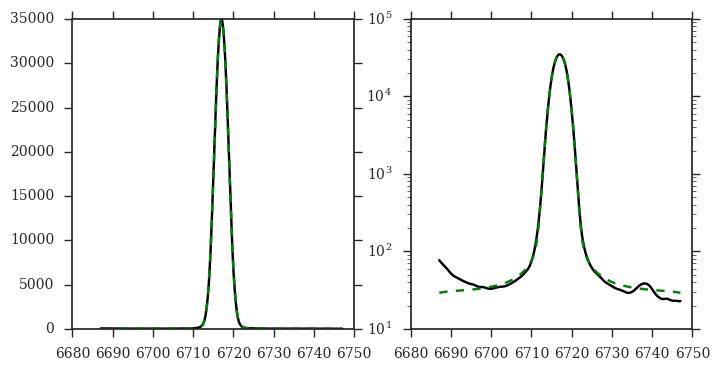

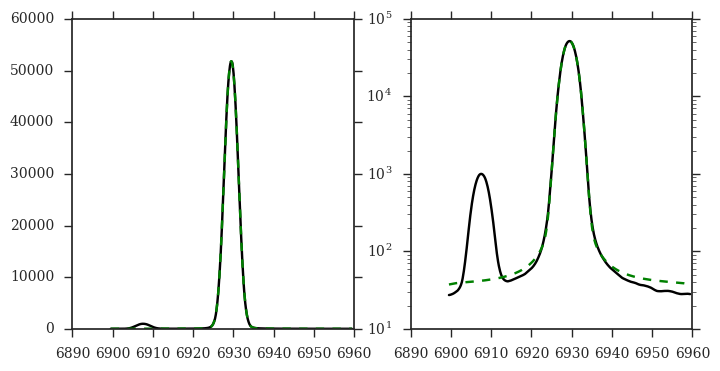

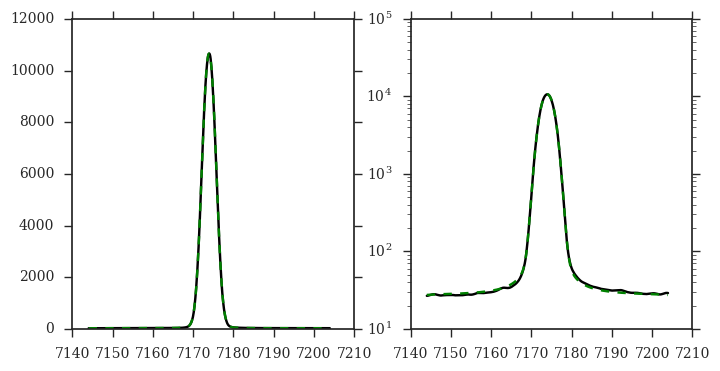

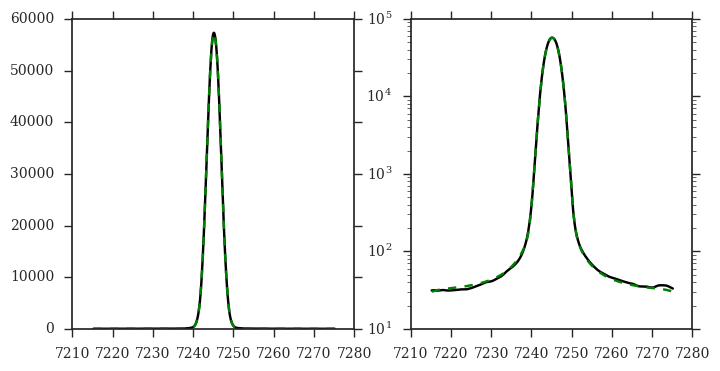

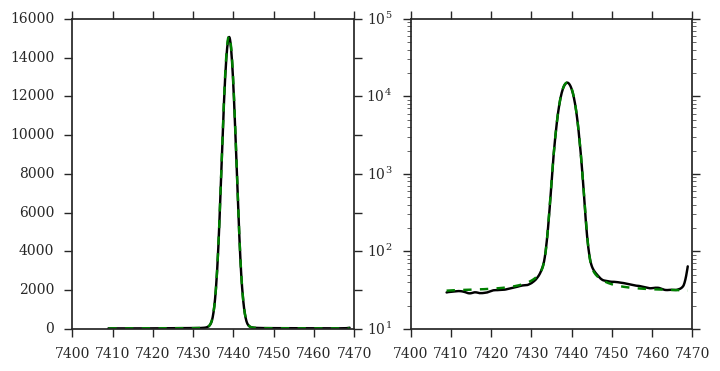

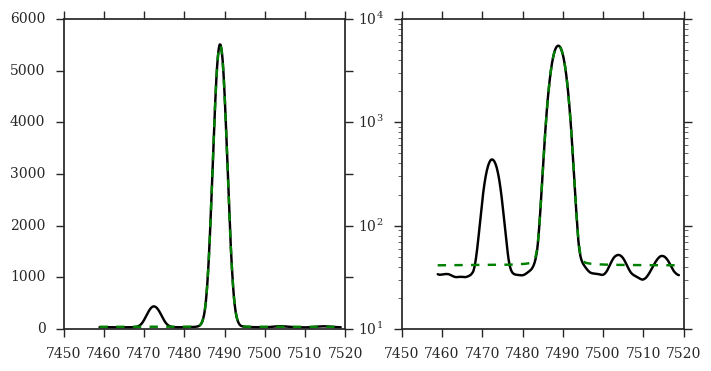

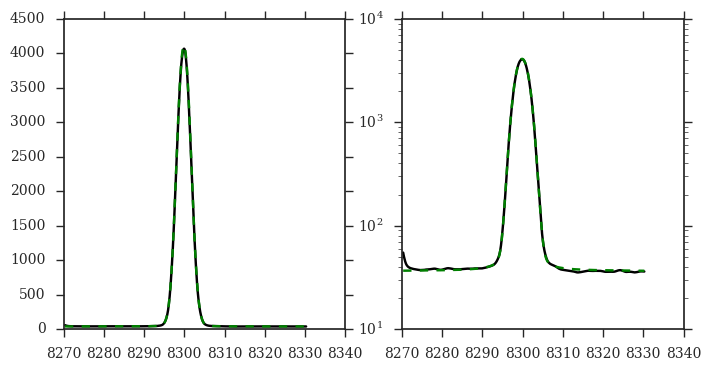

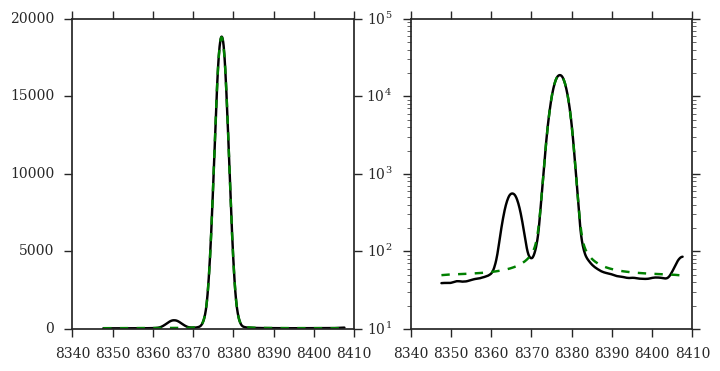

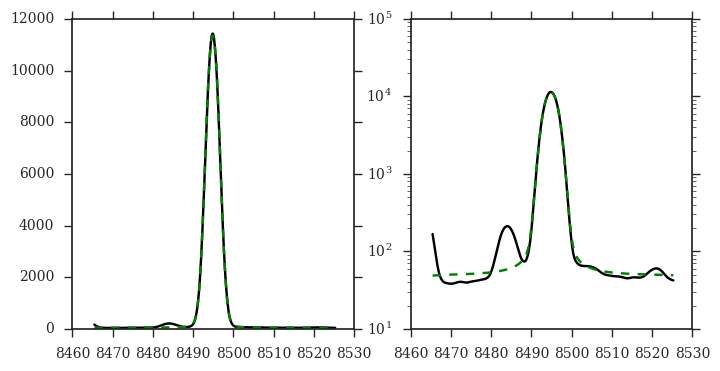

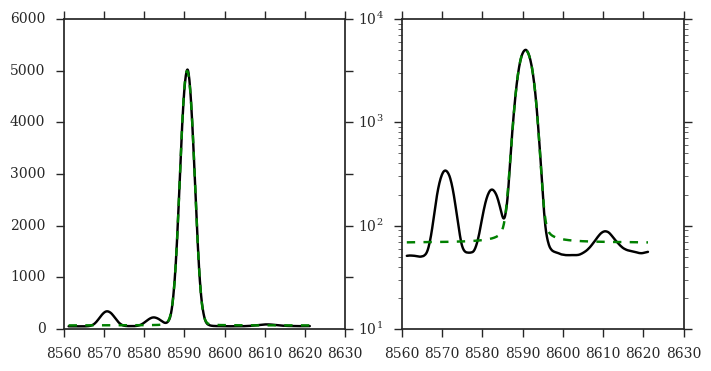

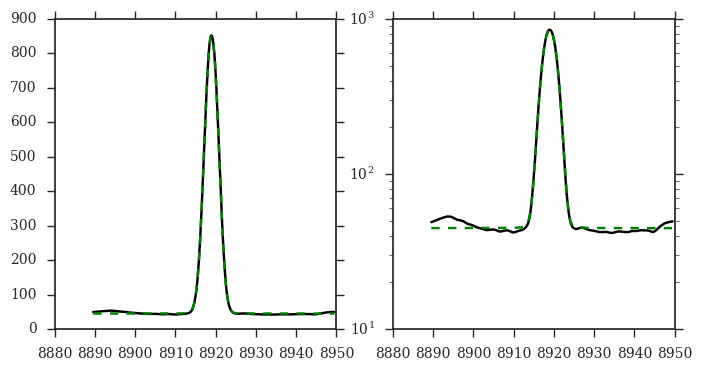

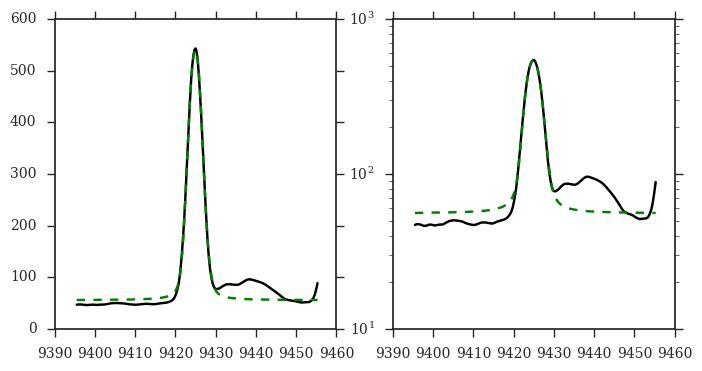

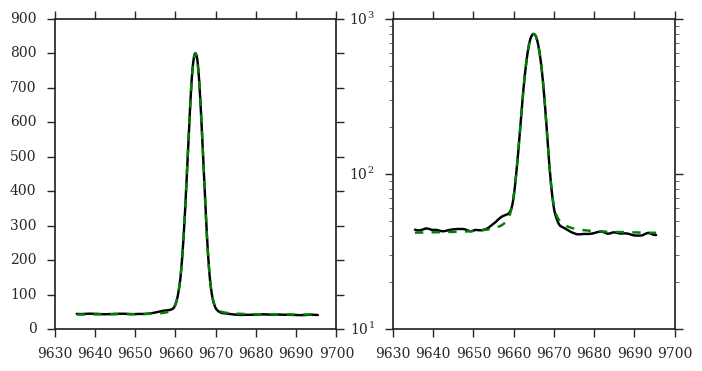

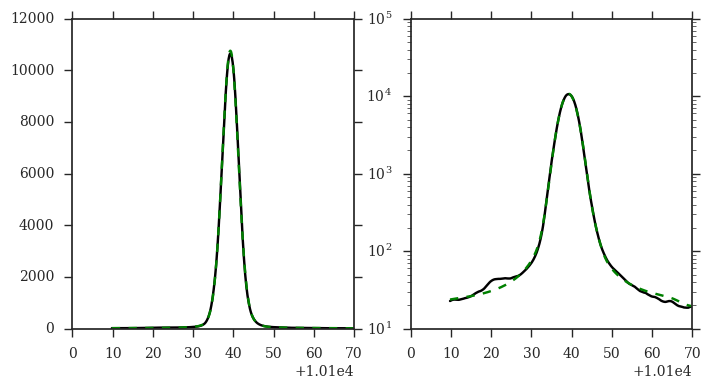

In [531]:
OUTPUT = []
for arcline in my_blue_lines_more:
    flux, wave, weights = window_arclines('blue', arcline, 30,blue_mean_arcline)
    mod = Model(my_profile)
    params = mod.make_params()
    params.add('amp1', value = 100, min = 0)
    params.add('amp2', value = 100, min = 0)
    params.add('center', value = arcline, vary = True)
    params.add('wave2', value = arcline+0.6, min = arcline, max = arcline+3)
    params.add('wave1', value = arcline-0.9, min = arcline-3, max = arcline)
    params.add('a', value = 100, min = 0)
    params.add('N', value = 30000, vary = True)
    params.add('sig1', value = 1, min = 0)
    params.add('sig2', value = 1, min = 0)
    params.add('c', value = 1, min = 0)

    model = mod.fit(flux, params, x = wave, weights = weights)
    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(8,4))
    ax1.plot(wave, flux,'k-')
    ax1.plot(wave,model.best_fit,'g--')
    ax2.semilogy(wave, flux,'k-')
    ax2.semilogy(wave,model.best_fit,'g--')
    plt.show()

    OUTPUT.append([np.sum(flux), model.chisqr, model.redchi, model.params['amp1'].value,model.params['amp2'].value,
                   model.params['a'].value,model.params['center'].value,
                   model.params['wave1'].value,model.params['wave2'].value,model.params['N'].value,
                   model.params['sig1'].value,model.params['sig2'].value, model.params['c'].value])
    
for arcline in my_red_lines_more:
    flux, wave, weights = window_arclines('red', arcline, 30,red_mean_arcline)
    mod = Model(my_profile)
    params = mod.make_params()
    params.add('amp1', value = 100, min = 0)
    params.add('amp2', value = 100, min = 0)
    params.add('center', value = arcline, vary = True)
    params.add('wave2', value = arcline+0.6, min = arcline, max = arcline+3)
    params.add('wave1', value = arcline-0.9, min = arcline-3, max = arcline)
    params.add('a', value = 100, min = 0)
    params.add('N', value = 50000, min = 0, max = 83200)
    params.add('sig1', value = 1, min = 0)
    params.add('sig2', value = 1, min = 0)
    params.add('c', value = 1, min = 0)

    model = mod.fit(flux, params, x = wave, weights = weights)
    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(8,4))
    model = mod.fit(flux, params, x = wave, weights = weights)
    ax1.plot(wave, flux,'k-')
    ax1.plot(wave,model.best_fit,'g--')
    ax2.semilogy(wave, flux,'k-')
    ax2.semilogy(wave,model.best_fit,'g--')
    plt.show()
    OUTPUT.append([np.sum(flux), model.chisqr, model.redchi, model.params['amp1'].value,model.params['amp2'].value,
                   model.params['a'].value,model.params['center'].value,
                   model.params['wave1'].value,model.params['wave2'].value,model.params['N'].value,
                   model.params['sig1'].value,model.params['sig2'].value, model.params['c'].value])

In [534]:
cc = ['sum','chi2','redchi','amp1','amp2','a','center','wave1','wave2','N','sig1','sig2','c']
df = pd.DataFrame(np.vstack(OUTPUT),columns = cc)
df = df[df['N']>0]

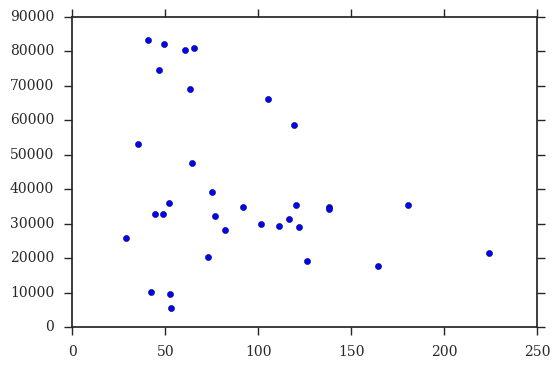

In [535]:
plt.scatter(df['a'],df['N'])

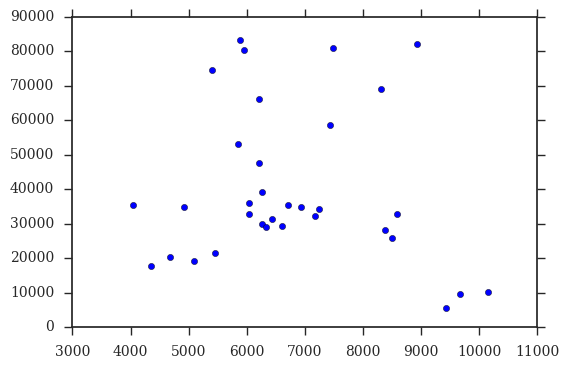

In [536]:
plt.scatter(df['center'],df['N'])

## What is N_eff?

In [549]:
def chi2_plot(arcline, color):
    if color == 'blue':
        flux, wave, weights = window_arclines('blue', arcline, 30, blue_mean_arcline) 
        max_N = 83200
    elif color == 'red':
        flux, wave, weights = window_arclines('red', arcline, 30,red_mean_arcline)
        max_N = 64000
        
    mod = Model(my_profile)
    params = mod.make_params()
    params.add('amp1', value = 100, min = 0)
    params.add('amp2', value = 100, min = 0)
    params.add('center', value = arcline, vary = True)
    params.add('wave2', value = arcline+0.6, min = arcline, max = arcline+3)
    params.add('wave1', value = arcline-0.9, min = arcline-3, max = arcline)
    params.add('a', value = 100, min = 0)
    params.add('N', value = 50000, min = 0, max = 83200)
    params.add('sig1', value = 1, min = 0)
    params.add('sig2', value = 1, min = 0)
    params.add('c', value = 1, min = 0)

    pre_model = mod.fit(flux, params, x = wave, weights=weights)

    model_params = []
    for N_eff in np.linspace(1000, 50000, 100):
        aa = pre_model.params['a']
        for amp in np.linspace(10,600,100):
            mod = Model(my_profile)
            params = mod.make_params()
            params.add('amp1', value = pre_model.params['amp1'], vary=False)
            params.add('amp2', value = pre_model.params['amp2'], vary=False)
            params.add('center', value = pre_model.params['center'], vary=False)
            params.add('wave1', value = pre_model.params['wave1'], vary=False)
            params.add('wave2', value = pre_model.params['wave2'], vary=False)
            params.add('a', value = amp, vary = False)
            params.add('N', value = N_eff, vary=False)
            params.add('sig1', value = pre_model.params['sig1'], vary=False)
            params.add('sig2', value = pre_model.params['sig2'], vary=False)
            params.add('c', value = pre_model.params['c'], vary=False)
            model = mod.fit(flux, params, x = wave, weights=weights)

            model_params.append([model.params['N'].value, model.params['a'].value, model.redchi])
            
    Mp = pd.DataFrame(model_params, columns = ['N','Amp','chi2'])
    Mp = Mp[Mp['chi2']<100]
    return wave, flux, pre_model, Mp

In [542]:
my_bright_blue_lines = [ 4799.912 ,  5085.822 ,  5460.753]

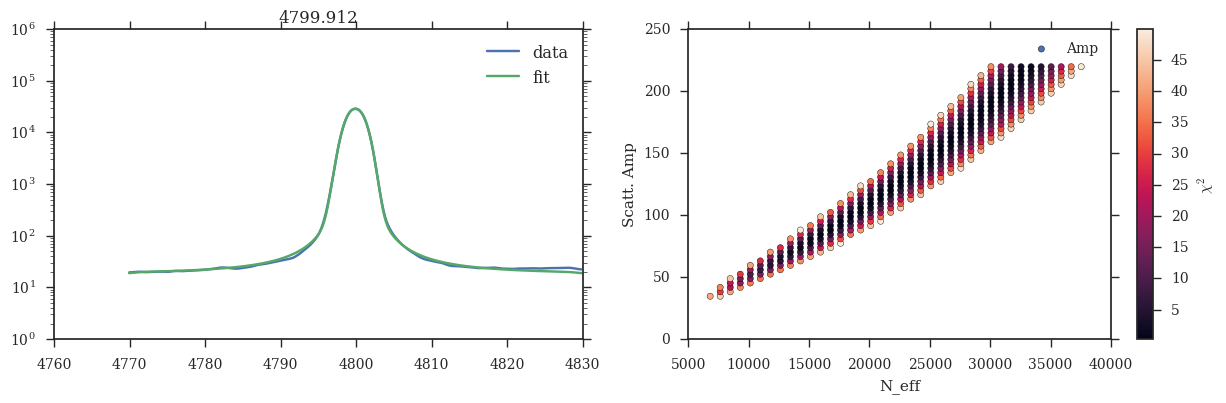

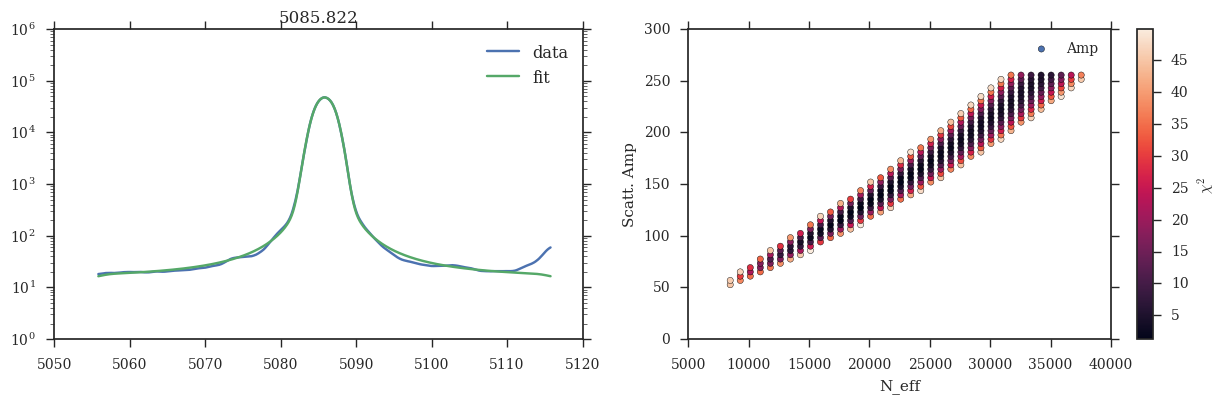

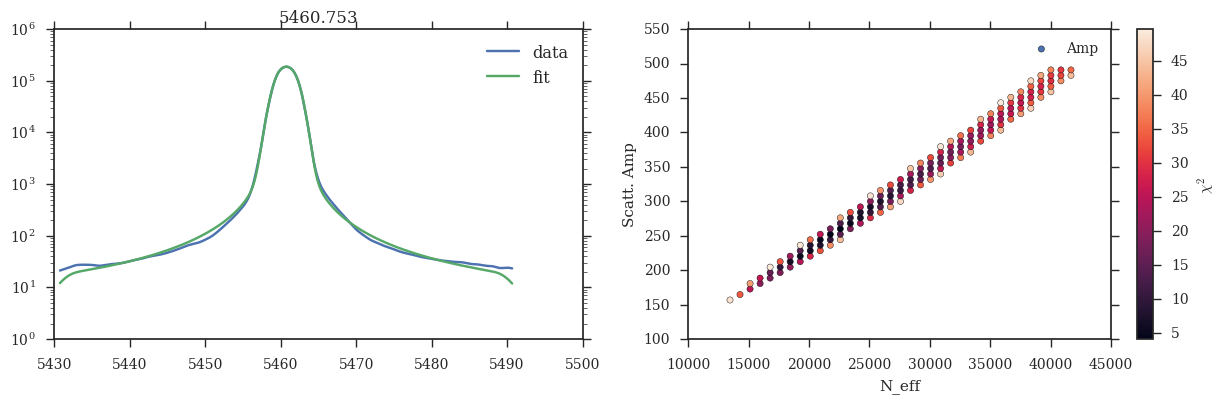

In [543]:
for line in my_bright_blue_lines:
    wave, flux, pre_model, Mp = chi2_plot(line,'blue')
    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,4))
    ax1.semilogy(wave, flux, label = 'data')
    ax1.semilogy(wave, pre_model.best_fit, label = 'fit')
    ax1.legend(prop=font)
    ax1.set_ylim(pow(10,0), pow(10,6))
    ax1.set_title(line)
    s = ax2.scatter(Mp['N'], Mp['Amp'], c = Mp['chi2'])
    plt.colorbar(s, ax = ax2, cmap = 'jet', label = '$\chi^{2}$')
    ax2.set_xlabel("N_eff")
    ax2.set_ylabel("Scatt. Amp")
    ax2.legend()
    plt.show()

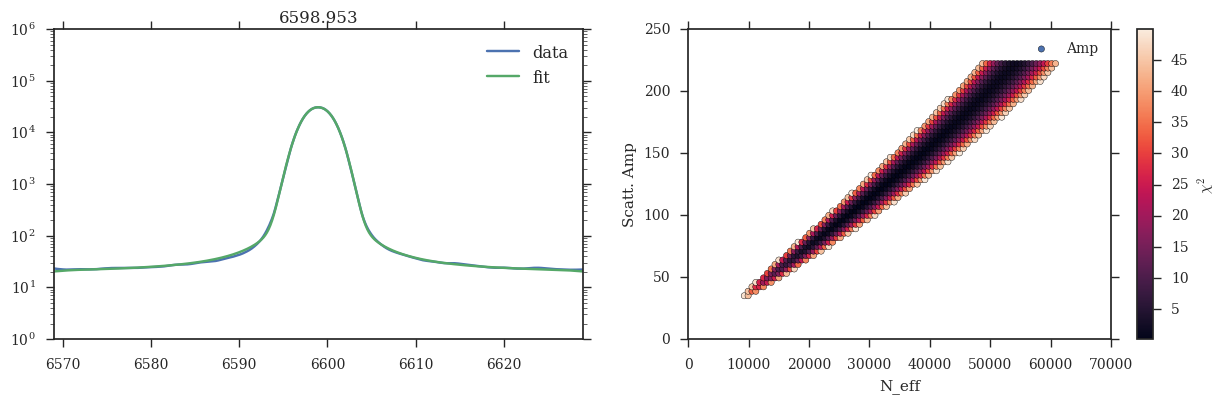

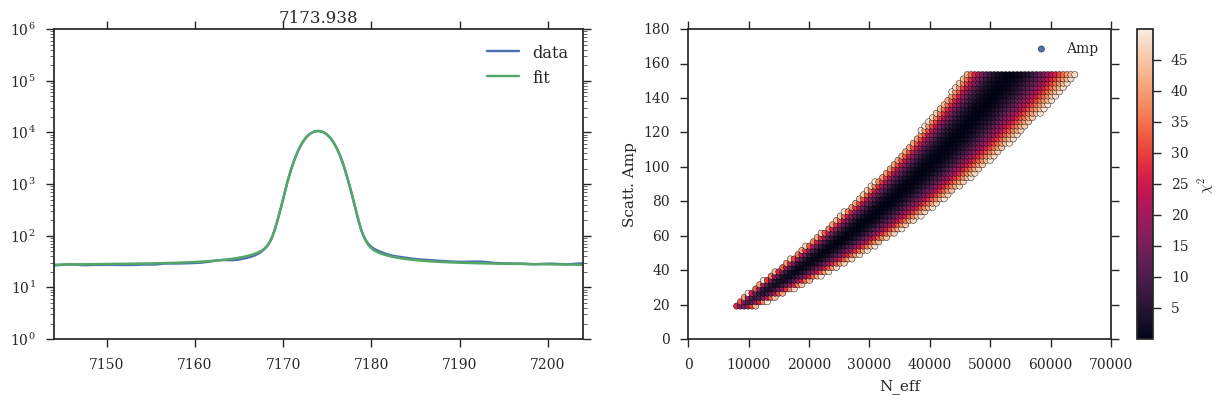

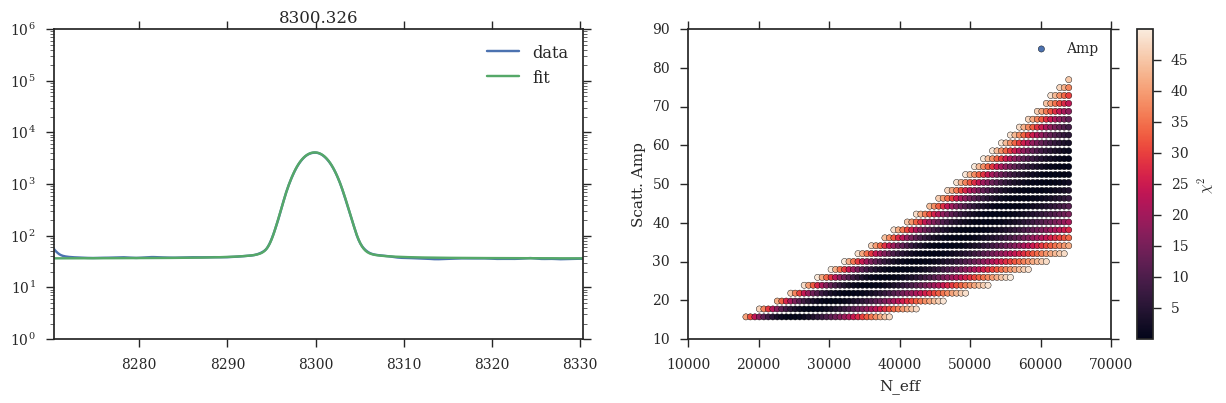

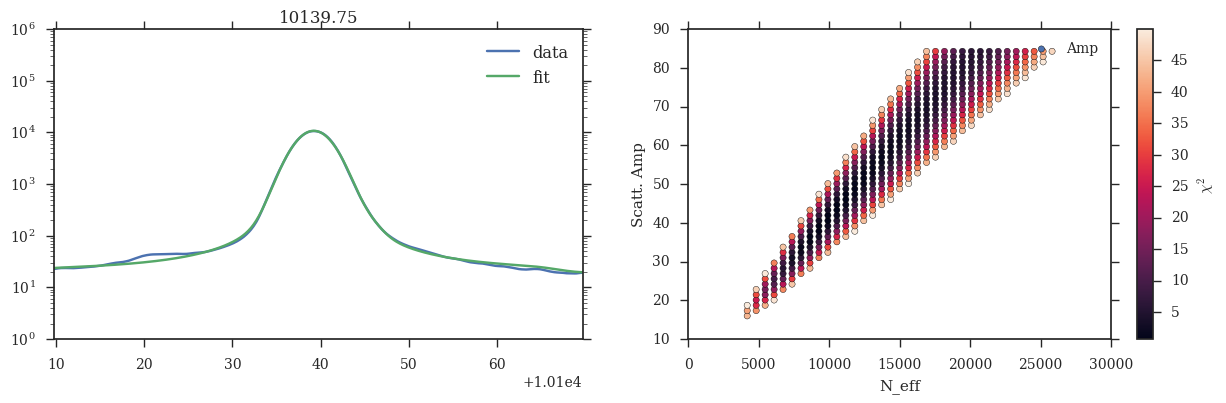

In [545]:
for line in my_red_lines:
    wave, flux, pre_model, Mp = chi2_plot(line,'red')
    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,4))
    ax1.semilogy(wave, flux, label = 'data')
    ax1.semilogy(wave, pre_model.best_fit, label = 'fit')
    ax1.legend(prop=font)
    ax1.set_ylim(pow(10,0), pow(10,6))
    ax1.set_title(line)
    ax1.set_xlim(wave[0], wave[-1])
    s = ax2.scatter(Mp['N'], Mp['Amp'], c = Mp['chi2'])
    plt.colorbar(s, ax = ax2, cmap = 'jet', label = '$\chi^{2}$')
    ax2.set_xlabel("N_eff")
    ax2.set_ylabel("Scatt. Amp")
    ax2.legend()
    plt.show()

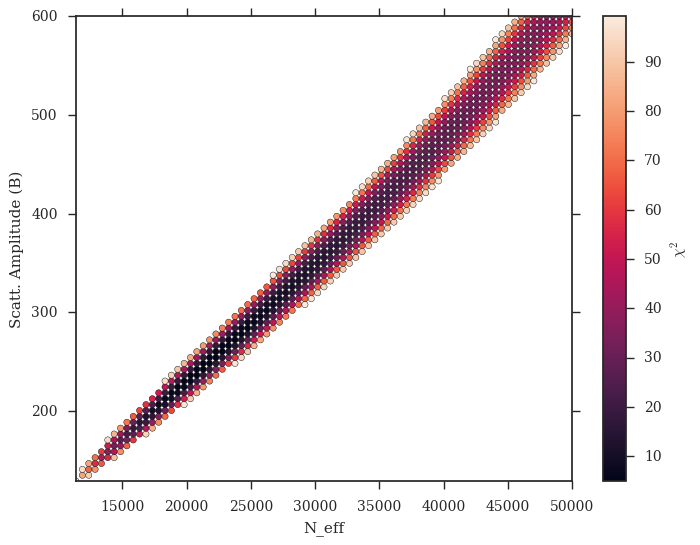

In [551]:
wave, flux, pre_model, Mp = chi2_plot(5460.753,'blue')
plt.figure(figsize=(8,6))
s = plt.scatter(Mp['N'], Mp['Amp'], c = Mp['chi2'])
plt.colorbar(s, cmap = 'jet',label = '$\chi^{2}$')
plt.xlabel("N_eff")
plt.ylabel("Scatt. Amplitude (B)")
ymin, ymax = np.percentile(Mp['Amp'], (0, 100))
xmin, xmax = np.percentile(Mp['N'], (0,100))
plt.ylim(ymin, ymax)
plt.xlim(xmin, xmax)
plt.savefig("/Users/parkerf/Research/Thesis/thesis_doc/images/chi2_N.png")

### Look at rest of model

This requires higher levels of statistics

In [556]:
def run_model(arcline, color, mean_arcfile, fix_N = False, make_plots = True):
    flux, wave, weights = window_arclines(color, arcline, 30, mean_arcfile) 
    if color == 'blue':
        N = 25000
    elif color == 'red':
        N = 40000


    mod = Model(my_profile)
    params = mod.make_params()
    
    params.add('amp1', value = 100, min = 0)
    params.add('amp2', value = 100, min = 0)
    params.add('center', value = arcline, vary = True)
    params.add('wave2', value = arcline+0.6, min = arcline, max = arcline+3)
    params.add('wave1', value = arcline-0.9, min = arcline-3, max = arcline)
    params.add('a', value = 100, min = 0)
    params.add('N', value = N, vary=True)
    params.add('sig1', value = 1, min = 0)
    params.add('sig2', value = 1, min = 0)
    params.add('c', value = 1, min = 0)
    if fix_N:
        params.add('N', value = N, vary=False)

    model = mod.fit(flux, params, x = wave, weights=weights)
    total_flux = np.sum(model.best_fit)
    if make_plots:
        fig, (ax1, ax2) = plt.subplots(1,2,figsize=(6,6))
        ax1.plot(wave, flux,label='data')
        ax1.plot(wave, model.best_fit, '--',label = 'fit')
        ax2.semilogy(wave, flux,label='data')
        ax2.semilogy(wave, model.best_fit, '--',label = 'fit')
        ax1.legend()
        ax2.legend()
        plt.show()
    return model, total_flux, arcline

list_of_params = ['amp1','amp2','a','center','wave1','wave2','N','sig1','sig2','c']

def collect_params(model, total_flux, line):
    p = model.params
     
    features = [model.redchi, total_flux, line]
    for param in list_of_params:
        features.append(p[param].value)
    return features

In [559]:
fit_stats = []
for arcfile in blue_mean_arcfiles:
    mean_arcdata = np.load(arcfile)
    for l in my_blue_lines_more:
        mod,  tf, line = run_model(l, 'blue', mean_arcdata,make_plots=False)
        fit_stats.append(collect_params(mod, tf, line))

In [560]:
fit_stats_N = []
for arcfile in blue_mean_arcfiles:
    mean_arcdata = np.load(arcfile)
    for l in my_blue_lines_more:
        mod,  tf, line = run_model(l, 'blue', mean_arcdata, fix_N = True, make_plots=False)
        fit_stats_N.append(collect_params(mod, tf, line))

In [561]:
fit_stats = np.vstack([fit_stats])
fit_stats_N = np.vstack([fit_stats_N])

In [562]:
new_params = ['chi2','total_flux','line']
df1 = pd.DataFrame(fit_stats, columns = new_params+list_of_params)
df1.head()

chi2    total_flux      line          amp1          amp2  \
0  23.608898  1.213183e+06  4046.572    103.273393    182.642649   
1  89.603280  3.309487e+06  4358.337    126.956515    315.282196   
2  10.563317  5.417206e+05  4678.149     76.838422    131.344390   
3   0.320416  1.325983e+06  4799.912  10180.822737  19570.986691   
4   0.058335  3.277199e+04  4916.070    161.142346    403.136697   

              a       center        wave1        wave2             N  \
0    131.676241  4046.620535  4045.650981  4046.941926  2.778247e+04   
1    187.627643  4358.420397  4357.226276  4358.560933  2.328568e+04   
2    103.178467  4678.155587  4677.225960  4678.585682  3.901516e+04   
3  12618.027633  4799.300344  4799.499103  4800.883985  3.089913e+06   
4      0.952630  4916.244361  4914.845825  4916.250008  5.328533e+04   

       sig1      sig2          c  
0  0.902794  1.023038   7.468993  
1  0.915985  1.105143  22.298606  
2  0.981660  1.097606  28.079400  
3  0.970694  1.114336  26.914118  
4  0.985765  1.183080  25.894338

In [592]:
dfN = pd.DataFrame(fit_stats_N, columns = new_params+list_of_params)
dfN.head()

chi2    total_flux      line        amp1        amp2           a  \
0  23.670944  1.211952e+06  4046.572  247.150923  425.276774   52.718101   
1  89.450079  3.314486e+06  4358.337  154.975642  380.763010  178.559302   
2  10.673997  5.411054e+05  4678.149   63.495057   94.274850   85.126327   
3   0.562611  1.323112e+06  4799.912   97.362095  163.519067  124.111205   
4   0.059856  3.287335e+04  4916.070  197.339093  391.253394    0.696442   

        center        wave1        wave2        N      sig1      sig2  \
0  4046.914202  4045.354844  4046.656815  25000.0  0.895412  1.014015   
1  4358.243910  4357.414688  4358.748983  25000.0  0.917348  1.103978   
2  4678.140202  4677.265174  4678.652371  25000.0  0.968993  1.065485   
3  4799.939236  4798.902098  4800.305958  25000.0  0.964690  1.088376   
4  4916.045137  4915.096826  4916.527778  25000.0  0.966910  1.134166   

           c  
0   6.735518  
1  22.300612  
2  26.634034  
3  24.819847  
4  25.751370

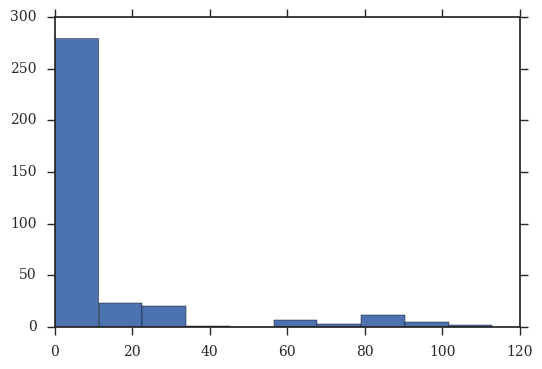

In [575]:
ret = plt.hist(dfN['chi2'])

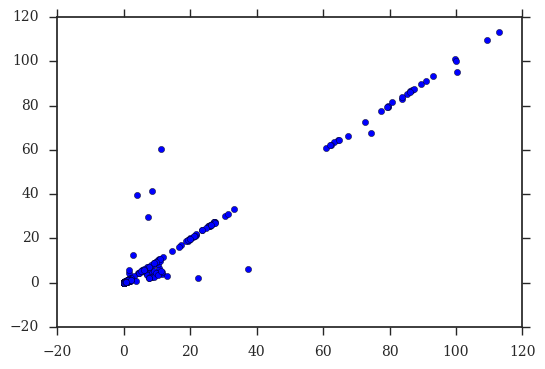

In [564]:
plt.scatter(dfN['chi2'],df1['chi2'])

In [606]:
dfNew = dfN[(dfN['chi2']<5)&(dfN['amp1']<300)&(dfN['amp2']<300)&(dfN['a']<300)]

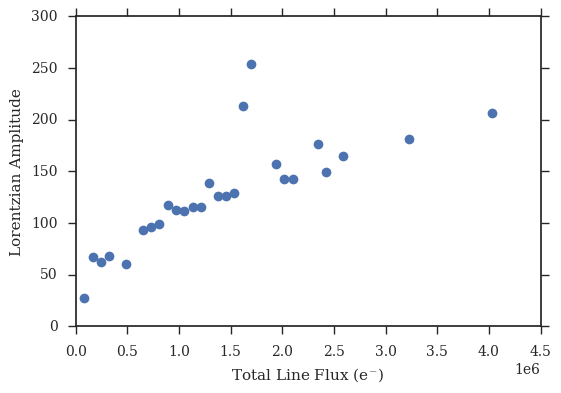

In [613]:
means, edges, numbers = stats.binned_statistic(dfNew['total_flux'], dfNew['a'], statistic = 'mean', bins = 50)
#plt.scatter(dfN['center'], dfN['amp1'])
plt.plot(edges[1:], means,'o')
plt.ticklabel_format(style='sci', axis='x',scilimits=(0,0))
plt.ylabel("Lorentzian Amplitude")
plt.xlabel("Total Line Flux (e$^{-}$)")
plt.savefig("/Users/parkerf/Research/Thesis/thesis_doc/images/lorentz_A.png")

In [616]:
print(np.mean(dfN['center'] - dfN['wave1']))
print(np.mean(dfN['wave2'] - dfN['center']))

0.8930609379975943
0.5012036033842187


In [617]:
print(np.mean(dfN['sig1']))
print(np.mean(dfN['sig2']))

1.0417393426091082
1.062884965436137


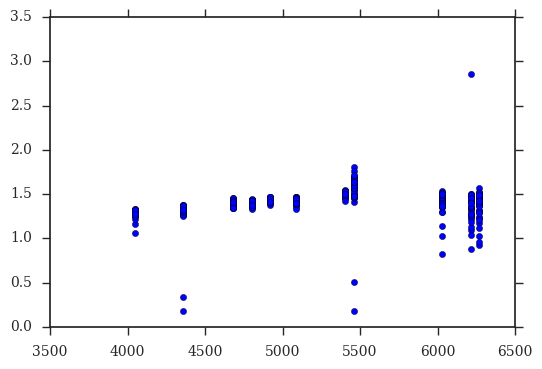

In [614]:
plt.scatter(dfN['center'],dfN['wave2'] - dfN['wave1'])

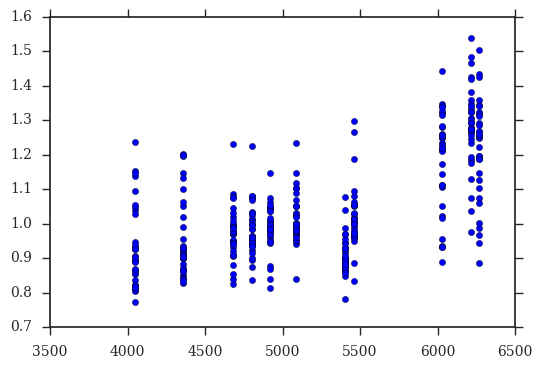

In [615]:
plt.scatter(dfN['center'],dfN['sig1'])

## Try to fit all the lines

First, how does windowing impact the fit?

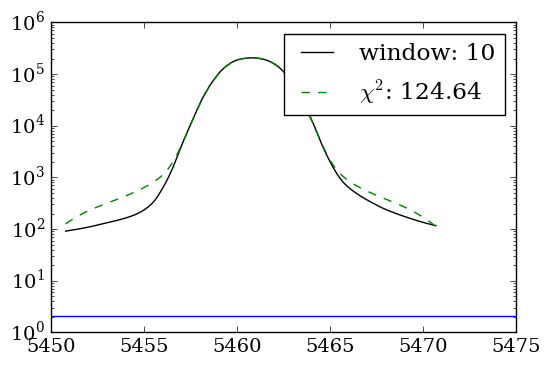

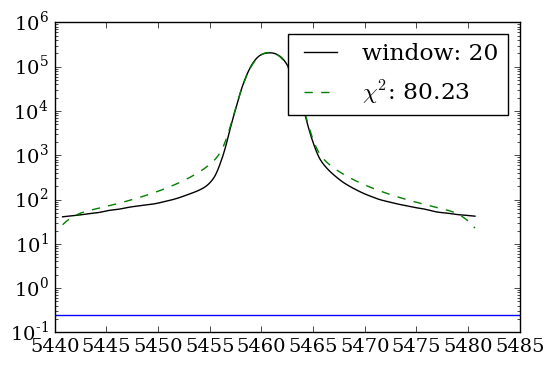

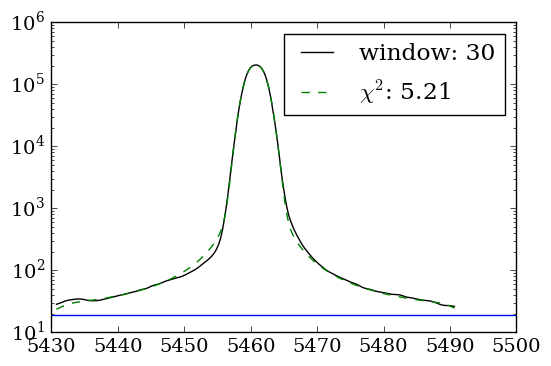

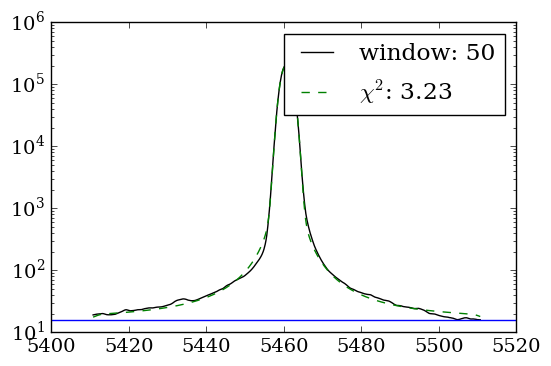

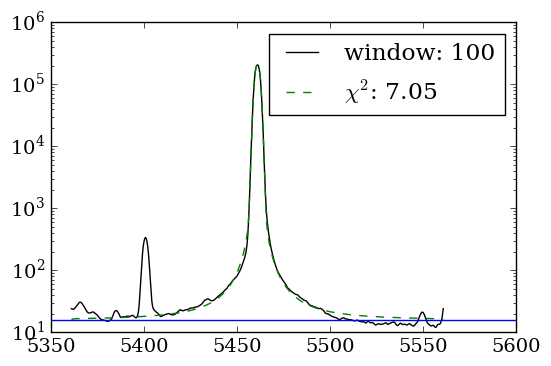

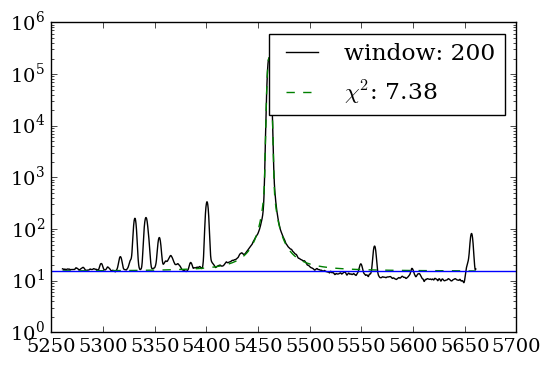

In [24]:
for window in [10,20,30,50,100,200]:
    arcline = my_blue_lines[2]
    flux, wave, weights = window_arclines('blue', arcline, window,blue_mean_arcline)
    mod = Model(my_profile)
    params = mod.make_params()
    params.add('amp1', value = 100, min = 0)
    params.add('amp2', value = 100, min = 0)
    params.add('center', value = arcline, vary = True)
    params.add('wave2', value = arcline+0.6, min = arcline, max = arcline+3)
    params.add('wave1', value = arcline-0.9, min = arcline-3, max = arcline)
    params.add('a', value = 100, min = 0)
    params.add('N', value = 30000, vary = True)
    params.add('sig1', value = 1, min = 0)
    params.add('sig2', value = 1, min = 0)
    params.add('c', value = 1, min = 0)

    model = mod.fit(flux, params, x = wave, weights = weights)
    init = mod.eval(params, x=wave)
    
    plt.figure()
    plt.semilogy(wave, flux,'k-',label = 'window: %d' %window)
    plt.semilogy(wave,model.best_fit,'g--', label = '$\chi^{2}$: %.2f'%model.redchi)
    plt.axhline(model.params['c'].value)
    plt.legend()
    plt.show()

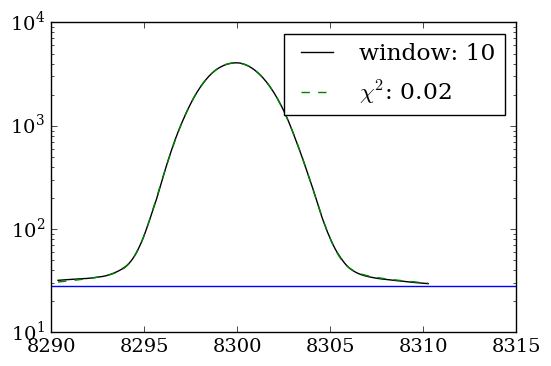

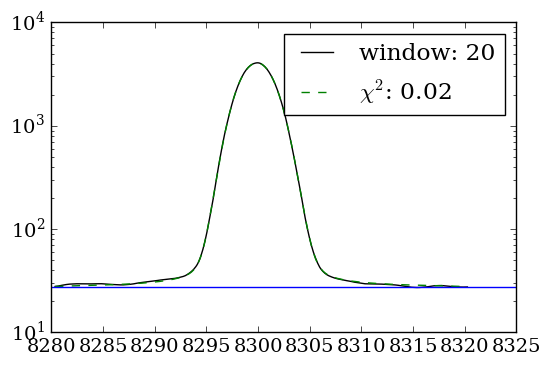

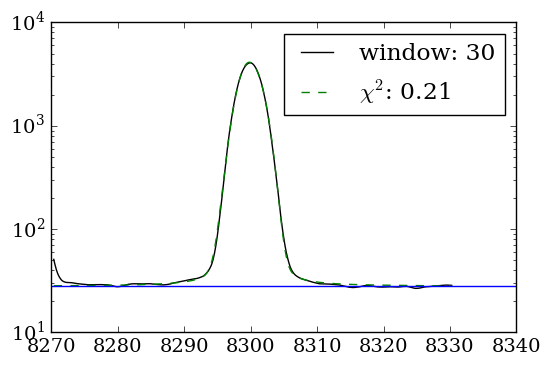

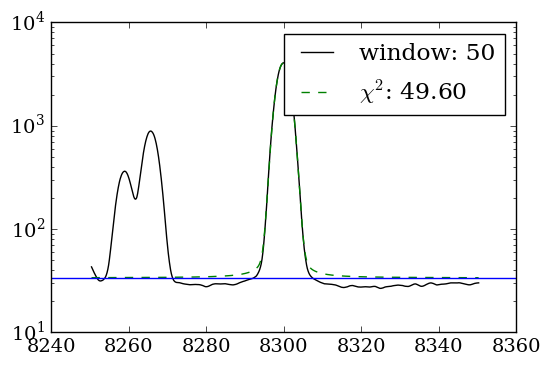

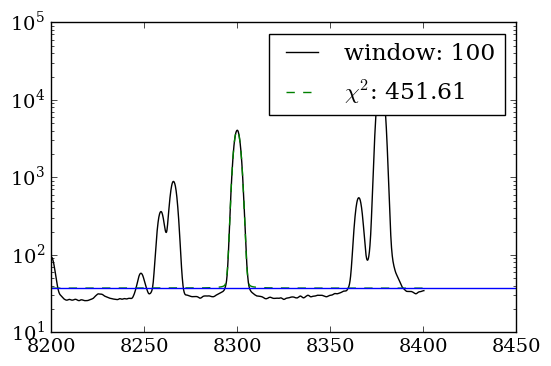

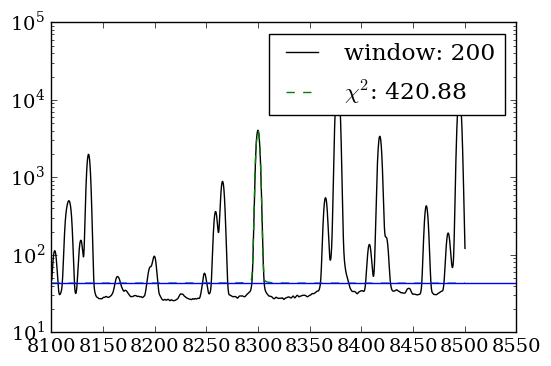

In [25]:
for window in [10,20,30,50,100,200]:
    arcline = my_red_lines[2]
    flux, wave, weights = window_arclines('red', arcline, window,red_mean_arcline)
    mod = Model(my_profile)
    params = mod.make_params()
    params.add('amp1', value = 100, min = 0)
    params.add('amp2', value = 100, min = 0)
    params.add('center', value = arcline, vary = True)
    params.add('wave2', value = arcline+0.6, min = arcline, max = arcline+3)
    params.add('wave1', value = arcline-0.9, min = arcline-3, max = arcline)
    params.add('a', value = 100, min = 0)
    params.add('N', value = 30000, vary = True)
    params.add('sig1', value = 1, min = 0)
    params.add('sig2', value = 1, min = 0)
    params.add('c', value = 1, min = 0)

    model = mod.fit(flux, params, x = wave, weights = weights)
    init = mod.eval(params, x=wave)
    
    plt.figure()
    plt.semilogy(wave, flux,'k-',label = 'window: %d' %window)
    plt.semilogy(wave,model.best_fit,'g--', label = '$\chi^{2}$: %.2f'%model.redchi)
    plt.axhline(model.params['c'].value)
    plt.legend()
    plt.show()

### Try to remove each line and replace with constant term

In [33]:
wave = np.linspace(3600,6500,(6500-3600)*10)
flux = blue_mean_arcline
NewFlux = flux.copy()

for arcline in my_blue_lines_more:
    line_flux, line_wave, line_weights = window_arclines('blue', arcline, 30, flux)
    mod = Model(my_profile)
    params = mod.make_params()
    params.add('amp1', value = 100, min = 0)
    params.add('amp2', value = 100, min = 0)
    params.add('center', value = arcline, vary = True)
    params.add('wave2', value = arcline+0.6, min = arcline, max = arcline+3)
    params.add('wave1', value = arcline-0.9, min = arcline-3, max = arcline)
    params.add('a', value = 100, min = 0)
    params.add('N', value = 30000, vary = True)
    params.add('sig1', value = 1, min = 0)
    params.add('sig2', value = 1, min = 0)
    params.add('c', value = 1, min = 0)

    model = mod.fit(line_flux, params, x = line_wave, weights = line_weights)
    idx = np.where((wave>line_wave[0])&(wave<line_wave[-1]))
    NewFlux[idx] = model.params['c'].value


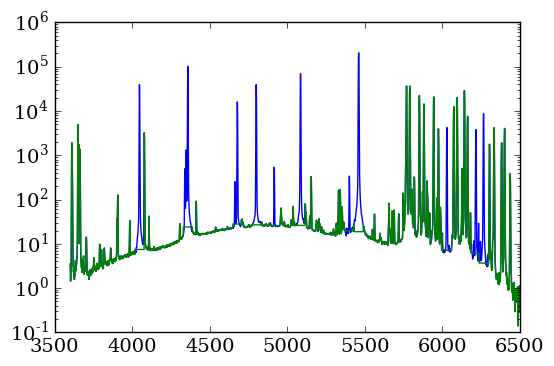

In [38]:
plt.semilogy(wave, flux)
plt.semilogy(wave, NewFlux)
#plt.xlim(5200,5600)

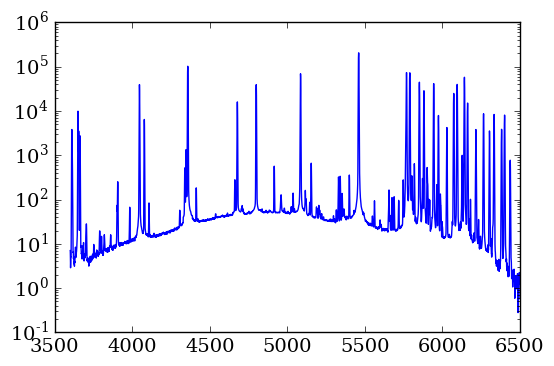

In [40]:
plt.semilogy(wave, flux - NewFlux)

In [141]:
flux, sigmas, wave, all_arc_lines = extract_data(bfile, 205)
weights = error_model(flux)


AA = []
AB = []
for line in all_arc_lines:
    AA.append(line_model(wave, line,sigmas))
    AB.append(np.exp(-0.5*((wave-line)/sigmas)**2))
AA = np.vstack(AA)
AB = np.vstack(AB)

AC = []
for i in range(2):
    AC.append(eval_legendre(i, wave))
AC = np.array(AC)
A = np.stack( np.vstack((AC,AA)), axis=1)
B = np.stack(np.vstack((AC,AB)), axis=1)

/Users/parkerf/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:5: DeprecationWarning: object of type <class 'numpy.ndarray'> cannot be safely interpreted as an integer.


In [142]:
results1 = sm.WLS(flux, A, weights = weights).fit()
params1 = results1.params
model1 = np.dot(A, params1)
results2 = sm.WLS(flux, B, weights = weights).fit()
params2 = results2.params
model2 = np.dot(B, params2)

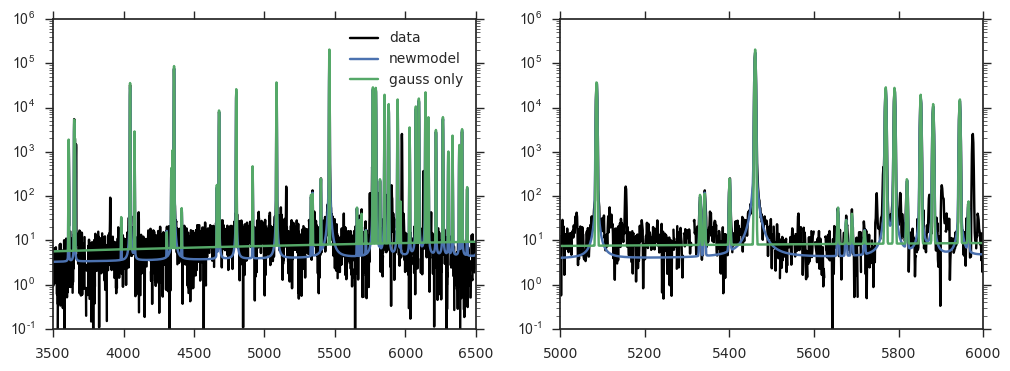

In [145]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,4))
ax1.semilogy(wave, flux,'k', label = 'data')
ax1.semilogy(wave, model1,label = 'newmodel')
ax1.semilogy(wave, model2, label = 'gauss only')
ax2.semilogy(wave, flux, 'k',label = 'data')
ax2.semilogy(wave, model1,label = 'newmodel')
#plt.semilogy(wave, flux - model1, label = 'residuals')
ax2.semilogy(wave, model2, label = 'gauss only')
ax1.set_xlim(3500,6500)
ax1.set_ylim(pow(10,-1),pow(10,6))
ax2.set_xlim(5000,6000)
ax2.set_ylim(pow(10,-1),pow(10,6))
ax1.legend()

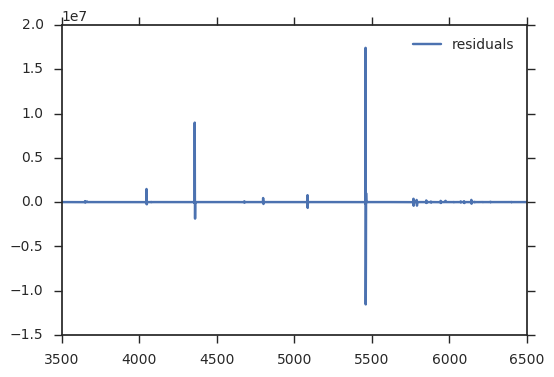

In [149]:
plt.figure()
plt.plot(wave, (flux - model1)/error_model(flux), label = 'residuals')
plt.xlim(3500,6500)
#plt.ylim(pow(10,-1),pow(10,6))
plt.legend()

In [150]:
flux, sigmas, wave, all_arc_lines = extract_data(rfile, 10)
weights = error_model(flux)

AA = []
AB = []
for line in all_arc_lines:
    AA.append(line_model(wave, line, sigmas))
    AB.append(np.exp(-0.5*((wave-line)/sigmas)**2))
AA = np.vstack(AA)
AB = np.vstack(AB)

AC = []
for i in range(1):
    AC.append(eval_legendre(i, wave))
AC = np.array(AC)
A = np.stack( np.vstack((AC,AA)), axis=1)

/Users/parkerf/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:5: DeprecationWarning: object of type <class 'numpy.ndarray'> cannot be safely interpreted as an integer.


In [151]:
results1 = sm.WLS(flux, A, weights = weights).fit()
params1 = results1.params
model1 = np.dot(A, params1)

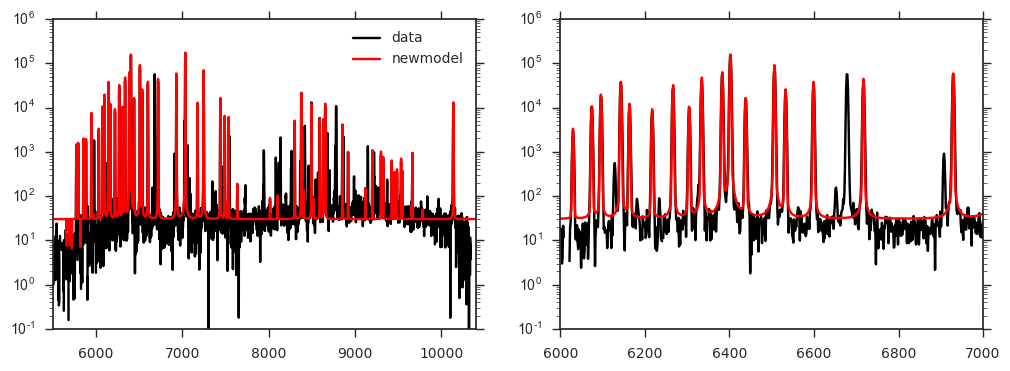

In [152]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,4))
ax1.semilogy(wave, flux, 'k-',label = 'data')
ax1.semilogy(wave, model1,'r-',label = 'newmodel')
ax2.semilogy(wave, flux, 'k-',label = 'data')
ax2.semilogy(wave, model1,'r-',label = 'newmodel')
#plt.semilogy(wave, flux - model1, label = 'residuals')
#plt.semilogy(wave, model2, label = 'oldmodel')
ax1.set_xlim(5500,10400)
ax1.set_ylim(pow(10,-1),pow(10,6))
ax2.set_xlim(6000,7000)
ax2.set_ylim(pow(10,-1),pow(10,6))
ax1.legend()

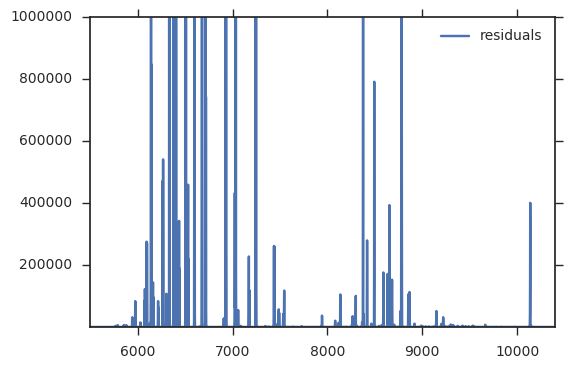

In [154]:
plt.figure()
plt.plot(wave, (flux - model1)/error_model(flux), label = 'residuals')
plt.xlim(5500,10400)
plt.ylim(pow(10,-1),pow(10,6))
plt.legend()

That's not going to work, so let's use a non-linear fitter

/Users/parkerf/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:5: DeprecationWarning: object of type <class 'numpy.ndarray'> cannot be safely interpreted as an integer.


[ 5400.5616  5460.753 ]


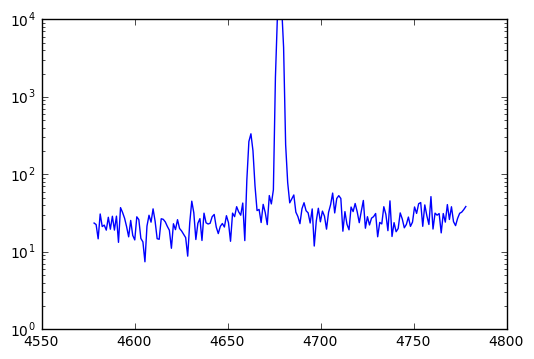

In [203]:
arc_line = my_blue_lines[2]
my_lines = my_blue_lines[6:8]
bfile = np.random.choice(blue_arc_files,1)[0]
flux, wave, weights = window_arclines(bfile, 205, arc_line, window_size = 100)
plt.semilogy(wave, flux)
plt.ylim(pow(10,0),pow(10,4))
print(my_lines)
#plt.xlim(4650,4670)

In [342]:
def scatter_profile(x,amplitude, center, N_eff):
    w = center/N_eff * (1/(np.sqrt(2)*np.pi))
    top = w**2.
    bot = ((x-center)**2+w**2)
    l = amplitude*top/bot 
    return l

In [343]:
def my_profile(x, amp1,amp2, a, center, wave1, wave2, sig1, sig2):
    N = 325
    gauss1 = amp1*np.exp(-(x-wave1)**2/(2*sig1**2.))
    gauss2 = amp2*np.exp(-(x-wave2)**2/(2*sig2**2.)) 
    core = gauss1 +gauss2
    
    scatt = scatter_profile(x, a, center, N)
    
    return core + scatt

In [352]:
def make_model(letter, line):
    pref = 'f%s_' % str(letter)
    model = Model(my_profile, prefix = pref)
    model.set_param_hint(pref+'amp1', value = 100, min = 0)
    model.set_param_hint(pref+'amp2', value = 100, min = 0)
    model.set_param_hint(pref+'center', value = line, min = line-1, max = line + 1,vary = True)
    model.set_param_hint(pref+'wave1', value = line+0.6, min = line-2,max = line+2, vary=True)
    model.set_param_hint(pref+'wave2', value = line-0.9, min = line-2,max = line+2,vary=True)
    model.set_param_hint(pref+'a', value = 100, min = 0)
    model.set_param_hint(pref+'sig1', value = 1, min = 0,max = 2)
    model.set_param_hint(pref+'sig2', value = 1, min = 0, max = 2)

    return model

In [377]:
flux, sigmas, wave, all_arc_lines = extract_data(bfile, 10)
weights = error_model(flux)

mod = None
for i, line in enumerate(all_arc_lines):
    this_mod = make_model(i, line)
    if mod is None:
        mod = this_mod
    else:
        mod = mod + this_mod

offset = ConstantModel()
offset.set_param_hint('c', value = 1)
#offset.set_param_hint('m', value = 1)
mod = mod + offset
params = mod.make_params()

/Users/parkerf/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:5: DeprecationWarning: object of type <class 'numpy.ndarray'> cannot be safely interpreted as an integer.


In [285]:
wave

array([ 2847.95560697,  2848.81651829,  2849.67762261, ...,  7218.14020715,
        7219.2561787 ,  7220.37212213])

In [378]:
out = mod.fit(flux, params, x= wave, weights = weights)

In [379]:
init = mod.eval(params, x=wave)

In [393]:
comps = out.eval_components()

In [394]:
comps.keys()

odict_keys(['f0_', 'f1_', 'f2_', 'f3_', 'f4_', 'f5_', 'f6_', 'f7_', 'f8_', 'f9_', 'f10_', 'f11_', 'f12_', 'f13_', 'f14_', 'f15_', 'f16_', 'f17_', 'f18_', 'f19_', 'f20_', 'f21_', 'f22_', 'f23_', 'f24_', 'f25_', 'f26_', 'f27_', 'f28_', 'f29_', 'f30_', 'f31_', 'f32_', 'f33_', 'f34_', 'f35_', 'f36_', 'f37_', 'f38_', 'f39_', 'f40_', 'f41_', 'f42_', 'f43_', 'f44_', 'constant'])

In [398]:
comps['constant']

3.6511419017034834

(0, 80000)

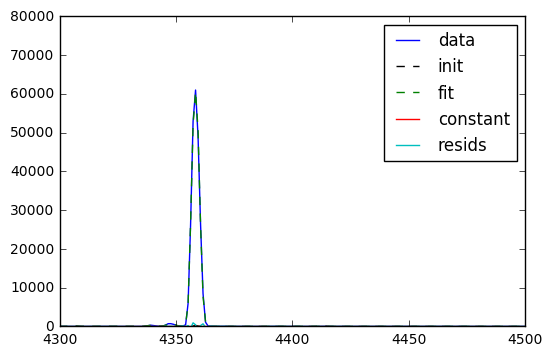

In [422]:
plt.plot(wave, flux, label = 'data')
plt.plot(wave, init, 'k--', label = 'init')
plt.plot(wave, out.best_fit, '--',label = 'fit')
plt.plot(wave, np.ones(len(wave))*comps['constant'], label = 'constant')
plt.plot(wave, (flux - out.best_fit)+comps['constant'], label = 'resids')
plt.legend()
plt.xlim(4300, 4500)
#plt.ylim(pow(10,-2), pow(10,6))
plt.ylim(0,80000)

(3500, 6500)

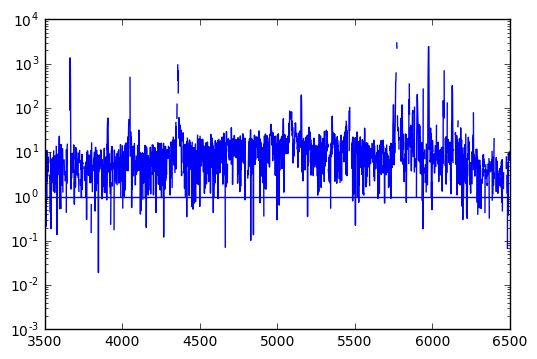

In [424]:
plt.semilogy(wave, (flux - out.best_fit)+ comps['constant'])
plt.axhline(1)
plt.xlim(3500, 6500)